# Multi-task learning with synthetic data

Can we fit a model to multiple targets to improve performance on a tabular learning example?

Steps:
1. Generate data
2. Specify a neural network architecture for modelling single and multiple outcomes
3. Train on a single outcome
4. Train on all outcomes
5. Try other architectures
6. Repeat the above with random seeds to get a performance comparis

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import polars as pl

plt.style.use("seaborn-v0_8-whitegrid")
pl.Config.set_fmt_str_lengths(30)

polars.config.Config

## Generate data

/var/folders/_v/nlh4h1yx2n1gd6f3szjlgxt40000gr/T/ipykernel_20630/1641650045.py:46: DeprecationWarning: `DataFrame.melt` is deprecated. Use `unpivot` instead, with `index` instead of `id_vars` and `on` instead of `value_vars`
  data=df.melt(id_vars=["datetime"]),


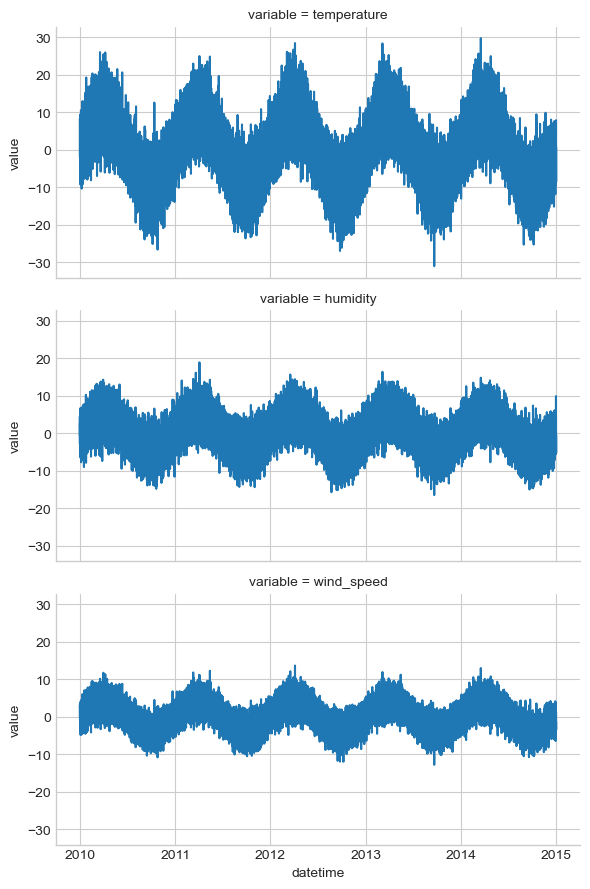

In [2]:
import datetime
from typing import List, Dict


def generate_data(n_years: float = 5, freq: str = "1H", seed: int = 42) -> pl.DataFrame:
    n_samples = int(n_years * 365 * 24)
    start_date = datetime.datetime(2010, 1, 1)
    end_date = start_date + datetime.timedelta(hours=n_samples - 1)
    date_range = pl.datetime_range(
        start=start_date, end=end_date, interval=freq, eager=True
    )

    # Generate yearly and daily sinusoidal patterns
    yearly_pattern = np.sin(2 * np.pi * date_range.dt.ordinal_day() / 365.25)
    daily_pattern = np.sin(2 * np.pi * date_range.dt.hour() / 24)

    # Generate time series data with noise on top of the sinusoidal patterns
    # centering at 0 to avoid bias learning taking all the training time
    rng = np.random.default_rng(seed)
    temperature_yearly_scale = 10
    temperature_daily_scale = 5
    temperature = (
        (temperature_yearly_scale + rng.normal(0, 3, n_samples)) * yearly_pattern
        + (temperature_daily_scale + rng.normal(0, 3, n_samples)) * daily_pattern
        + rng.normal(0, 1, n_samples)
        # +10
    )
    humidity = 0.5 * temperature + rng.normal(0, 2, n_samples)  # +50
    wind_speed = (
        0.3 * temperature + 0.2 * humidity + rng.normal(0, 1, n_samples)
    )  # + 10

    df = pl.DataFrame(
        {
            "datetime": date_range,
            "temperature": temperature,
            "humidity": humidity,
            "wind_speed": wind_speed,
        }
    )
    return df


df = generate_data()
g = sns.relplot(
    data=df.melt(id_vars=["datetime"]),
    x="datetime",
    y="value",
    row="variable",
    kind="line",
    height=3,
    aspect=2,
)

## Building models

Our task is to predict the weather given historic weather events.
We will predict each weather outcome given lagged values of the time series.

In [3]:
def create_lags(df: pl.DataFrame, columns: List[str], lags: List[int]) -> pl.DataFrame:
    df = df.with_columns(
        [
            pl.col(col).shift(lag).alias(f"{col}_lag_{lag}")
            for lag in lags
            for col in columns
        ]
    )
    df = df.drop_nulls()
    return df


lags = [1, 2, 5, 10, 24, 48, 72, 96]
df_lagged = create_lags(df, columns=df.columns[1:], lags=lags)
df_lagged

datetime,temperature,humidity,wind_speed,temperature_lag_1,humidity_lag_1,wind_speed_lag_1,temperature_lag_2,humidity_lag_2,wind_speed_lag_2,temperature_lag_5,humidity_lag_5,wind_speed_lag_5,temperature_lag_10,humidity_lag_10,wind_speed_lag_10,temperature_lag_24,humidity_lag_24,wind_speed_lag_24,temperature_lag_48,humidity_lag_48,wind_speed_lag_48,temperature_lag_72,humidity_lag_72,wind_speed_lag_72,temperature_lag_96,humidity_lag_96,wind_speed_lag_96
datetime[μs],f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
2010-01-05 00:00:00,0.637985,0.925252,-0.787306,-0.485036,-0.262405,-2.972897,-2.395915,-4.136439,-0.110433,0.84117,2.88351,1.250959,-0.775669,0.205819,-0.631928,-0.518869,-2.05956,-1.40386,0.57218,-0.003926,-2.400752,-0.761536,-2.376693,-1.719896,-1.869912,2.644923,-0.191163
2010-01-05 01:00:00,2.915944,0.165117,2.538671,0.637985,0.925252,-0.787306,-0.485036,-0.262405,-2.972897,-3.643692,-3.255064,-0.936923,-3.730544,-2.552969,-0.695401,2.891467,3.390896,0.848899,1.872926,1.647895,2.199458,-0.004084,0.918232,-1.345525,4.36177,1.073413,1.665154
2010-01-05 02:00:00,2.592064,1.467689,1.069381,2.915944,0.165117,2.538671,0.637985,0.925252,-0.787306,-2.913826,-1.532819,-1.922713,0.35176,-1.806871,0.749563,2.451263,-5.609235,0.34844,2.01036,-3.492822,0.814286,1.699677,-0.278471,0.319489,1.57783,-1.522763,0.817248
2010-01-05 03:00:00,4.660512,2.916416,1.490666,2.592064,1.467689,1.069381,2.915944,0.165117,2.538671,-2.395915,-4.136439,-0.110433,-1.237029,0.770381,1.864171,4.47904,0.133905,1.915223,4.062277,5.954006,2.870858,6.930973,3.757587,3.38761,6.976272,3.626425,3.220208
2010-01-05 04:00:00,4.994689,-1.128068,3.509711,4.660512,2.916416,1.490666,2.592064,1.467689,1.069381,-0.485036,-0.262405,-2.972897,3.827209,2.045751,1.844793,3.175023,5.578318,1.756106,5.424065,0.561712,1.060853,3.140539,0.46929,-0.505176,4.70927,2.265958,1.858327
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
2014-12-30 19:00:00,-3.823629,-0.68918,-0.567699,0.341363,-2.424681,-0.783147,-7.883683,-2.665909,-3.106036,-4.973574,-0.888294,-2.351587,5.016991,2.37395,2.040461,-7.948371,-4.229467,-3.455106,-4.414774,-3.941905,-2.291633,-11.908687,-1.783912,-2.66985,-5.826063,-3.797523,-2.239958
2014-12-30 20:00:00,-2.639205,-2.009972,-1.271762,-3.823629,-0.68918,-0.567699,0.341363,-2.424681,-0.783147,-4.873798,-0.823744,0.344937,5.099498,3.326915,1.248586,-7.600966,-1.382788,-0.7507,-5.466537,-3.737368,-2.528456,-5.27296,-1.701307,-1.154664,-2.467398,0.003497,-1.085946
2014-12-30 21:00:00,-8.543419,-5.256898,-3.462228,-2.639205,-2.009972,-1.271762,-3.823629,-0.68918,-0.567699,-3.263885,1.619482,1.08849,2.221999,0.606435,-0.537329,-5.578032,-5.280258,-2.075036,-2.363093,-0.890238,-2.070115,0.031713,-0.151272,-2.148263,-2.046125,-0.183945,-1.892012


Helper functions

In [4]:
import pytorch_lightning as pyl
import torch
import torch.nn as nn


def get_features_from_outcomes(df: pl.DataFrame, outcome_cols: List[str]) -> List[str]:
    feature_cols = [
        col
        for col in df.columns
        for outcome_col in outcome_cols
        if f"{outcome_col}_lag_" in col
    ]
    return feature_cols


def dataloader_from_df(
    df: pl.DataFrame, feature_cols: List[str], outcome_cols: List[str]
) -> torch.utils.data.DataLoader:
    dataset = torch.utils.data.TensorDataset(
        torch.Tensor(df[feature_cols].to_numpy()),
        torch.Tensor(df[outcome_cols].to_numpy()),
    )
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=2**10, shuffle=True)
    return dataloader


def plot_training_logs(model):
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.plot(np.array(model.log_train), label="train_LL")
    ax.plot(np.array(model.log_val), label="test_LL")
    ax.set(xlabel="Step", ylabel="Logloss")
    ax.legend()
    fig.show()


def calculate_loss(
    model, outcome_cols: List[str], dataloader: torch.utils.data.DataLoader
) -> List[Dict]:
    y_est_y = [[model(x), y] for x, y in dataloader]
    y_est = torch.concat([y_est for y_est, y in y_est_y], dim=0)
    y = torch.concat([y for y_est, y in y_est_y], dim=0)

    return [
        {"col": col, "mse": nn.MSELoss()(y[:, idx], y_est[:, idx]).item()}
        for idx, col in enumerate(outcome_cols)
    ]


def get_predictions(
    df: pl.DataFrame, model, feature_cols: List[str], outcome_cols: List[str]
) -> pl.DataFrame:
    y_est = model(torch.Tensor(df[feature_cols].to_numpy()))
    return pl.concat(
        [
            df,
            pl.DataFrame(
                y_est.detach().numpy(),
                schema=[f"{outcome_col}_est" for outcome_col in outcome_cols],
            ),
        ],
        how="horizontal",
    )


def plot_predictions(df_train_est, df_test_est, outcome_cols):
    for outcome_col in outcome_cols:
        fig, ax = plt.subplots(figsize=(6, 4))
        sns.lineplot(
            data=df_train_est.melt(
                id_vars=["datetime"], value_vars=[outcome_col, f"{outcome_col}_est"]
            ),
            x="datetime",
            y="value",
            hue="variable",
            ax=ax,
        )
        sns.lineplot(
            data=df_test_est.melt(
                id_vars=["datetime"], value_vars=[outcome_col, f"{outcome_col}_est"]
            ),
            x="datetime",
            y="value",
            hue="variable",
            ax=ax,
            legend=None,
        )
        ax.axvline(
            x=df_test_est["datetime"].min(), linestyle="--", color="k", alpha=0.5
        )
        ax.set(title=outcome_col)
        ax.legend(loc="upper left", bbox_to_anchor=(1, 0.5))


def loss_from_outcomes(
    model_callable,
    outcome_cols: List[str],
    feature_cols: List[str] = None,
    debug: bool = False,
    seed: int = None,
    df_train=None,
    df_test=None,
    epochs: int = 200,
):
    if df_train is None:
        # limited train data to make the problem hard
        df_train = df_lagged[: int(df_lagged.shape[0] * 0.5)].sample(fraction=0.01, seed=0)
        df_test = df_lagged[int(df_lagged.shape[0] * 0.5) :]

    if feature_cols is None:
        feature_cols = get_features_from_outcomes(df_train, outcome_cols)

    if seed is not None:
        torch.manual_seed(seed)
    dataloader_train = dataloader_from_df(df_train, feature_cols, outcome_cols)
    dataloader_test = dataloader_from_df(df_test, feature_cols, outcome_cols)

    model = model_callable(
        feature_cols,
        outcome_cols,
    )
    trainer = pyl.Trainer(
        max_epochs=epochs,
        accelerator="mps",
        enable_progress_bar=debug,
        enable_model_summary=debug,
    )
    trainer.fit(model, dataloader_train)

    if debug:
        plot_training_logs(model)

    loss_train = calculate_loss(model, outcome_cols, dataloader_train)
    loss_test = calculate_loss(model, outcome_cols, dataloader_test)

    df_train_est = get_predictions(df_train, model, feature_cols, outcome_cols)
    df_test_est = get_predictions(df_test, model, feature_cols, outcome_cols)

    if debug:
        plot_predictions(df_train_est, df_test_est, outcome_cols)

    return loss_train, loss_test

### Univariate model

We will just use dense networks instead of time series specific layers.

In [5]:
class SimpleMLP(pyl.LightningModule):
    def __init__(
        self,
        input_dim: int,
        hidden_dim: List[int] = None,
        output_dim: int = 1,
        learning_rate=1e-3,
    ):
        super().__init__()

        if hidden_dim is None:
            hidden_dim = [32, 16, 16, 16]

        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim[0]),
            nn.ReLU(),
            nn.Linear(hidden_dim[0], hidden_dim[1]),
            nn.ReLU(),
            nn.Linear(hidden_dim[1], hidden_dim[2]),
            nn.ReLU(),
            nn.Linear(hidden_dim[2], hidden_dim[3]),
            nn.Linear(hidden_dim[3], output_dim),
        )

        self.loss = nn.MSELoss()
        self.log_train = []
        self.log_val = []
        self.learning_rate = learning_rate

    def forward(self, x):
        return self.net(x)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(
            self.parameters(),
            lr=self.learning_rate,
        )
        return optimizer

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_est = self.forward(x)
        loss = self.loss(y, y_est)  # averages over all outcomes equally

        self.log("train_loss", loss, prog_bar=True, on_step=True)
        self.log_train.append(loss.detach().cpu().numpy())
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_est = self.forward(x)
        loss = self.loss(y, y_est)

        self.log("val_loss", loss, prog_bar=True, on_step=True)
        self.log_val.append(loss.cpu().numpy())
        return loss

We will fit a model to wind speed and then also to multiple outcomes to see if performance improves.

/var/folders/_v/nlh4h1yx2n1gd6f3szjlgxt40000gr/T/ipykernel_20630/2492728506.py:21: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /Users/runner/miniforge3/conda-bld/pytorch-recipe_1699313532615/work/torch/csrc/utils/tensor_numpy.cpp:212.)
  torch.Tensor(df[outcome_cols].to_numpy()),
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/stantoon/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:108: PossibleUserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_

Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=200` reached.
/var/folders/_v/nlh4h1yx2n1gd6f3szjlgxt40000gr/T/ipykernel_20630/2492728506.py:33: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/var/folders/_v/nlh4h1yx2n1gd6f3szjlgxt40000gr/T/ipykernel_20630/2492728506.py:69: DeprecationWarning: `DataFrame.melt` is deprecated. Use `unpivot` instead, with `index` instead of `id_vars` and `on` instead of `value_vars`
  data=df_train_est.melt(
/var/folders/_v/nlh4h1yx2n1gd6f3szjlgxt40000gr/T/ipykernel_20630/2492728506.py:78: DeprecationWarning: `DataFrame.melt` is deprecated. Use `unpivot` instead, with `index` instead of `id_vars` and `on` instead of `value_vars`
  data=df_test_est.melt(
/var/folders/_v/nlh4h1yx2n1gd6f3szjlgxt40000gr/T/ipykernel_20630/2492728506.py:69: DeprecationWarning: `DataFrame.melt` is deprecated. Use `unpivot` instead, with `index` instead of `id_vars` and `on` instead of `value_vars`
  data=df_train_est.melt(
/var/folders/_v/nlh4h1yx2n1gd

outcome_cols,fold,col,mse
str,str,str,f64
"""humidity_wind_speed""","""test""","""wind_speed""",3.762761
"""temperature_humidity_wind_spee…","""test""","""wind_speed""",3.420747
"""wind_speed""","""test""","""wind_speed""",3.584574
"""humidity_wind_speed""","""train""","""wind_speed""",2.682084
"""temperature_humidity_wind_spee…","""train""","""wind_speed""",2.61799
"""wind_speed""","""train""","""wind_speed""",2.608555


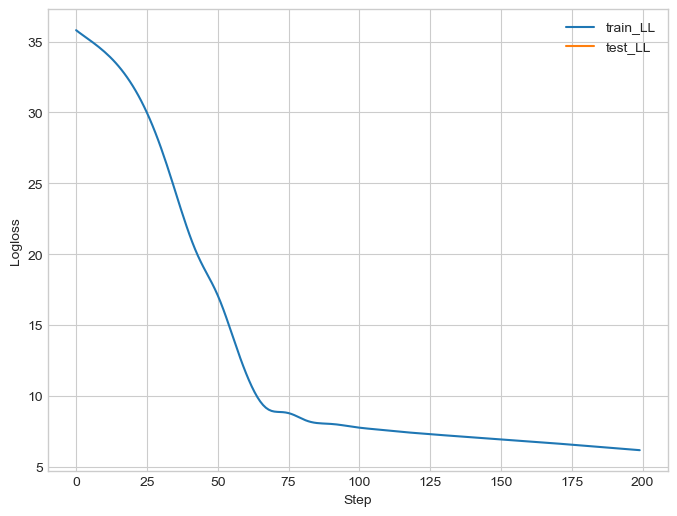

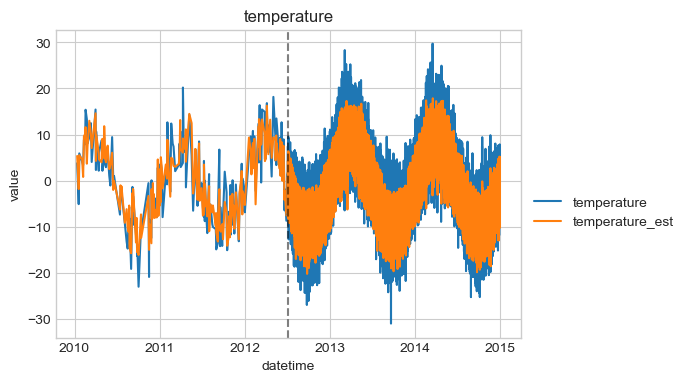

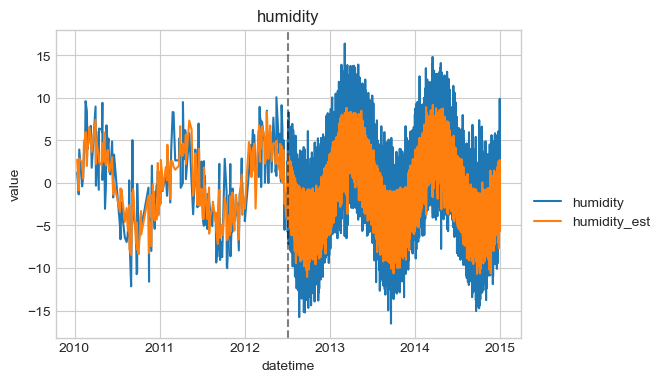

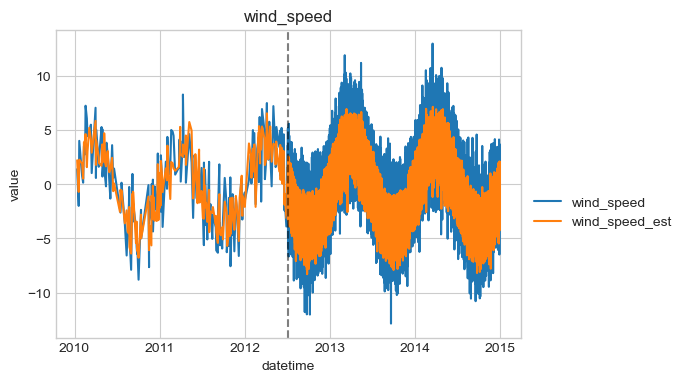

In [6]:
outcome_groups = [
    ["wind_speed"],
    ["humidity", "wind_speed"],
    ["temperature", "humidity", "wind_speed"],
]
losses = []
for outcome_cols in outcome_groups:
    loss_train, loss_test = loss_from_outcomes(
        outcome_cols=outcome_cols,
        model_callable=lambda feature_cols, outcome_cols: SimpleMLP(
            input_dim=len(feature_cols),
            output_dim=len(outcome_cols),
            learning_rate=1e-3,
        ),
        debug=len(outcome_cols)==3,
    )
    losses.extend(
        [
            {"outcome_cols": "_".join(outcome_cols), "fold": "train", **loss}
            for loss in loss_train
        ]
    )
    losses.extend(
        [
            {"outcome_cols": "_".join(outcome_cols), "fold": "test", **loss}
            for loss in loss_test
        ]
    )

losses = pl.DataFrame(losses)
losses.sort(["col", "fold", "outcome_cols"]).filter(pl.col("col") == "wind_speed")


When predicting all outcomes the model converges ok and the predictions look reasonable.

/var/folders/_v/nlh4h1yx2n1gd6f3szjlgxt40000gr/T/ipykernel_20630/3731575569.py:11: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


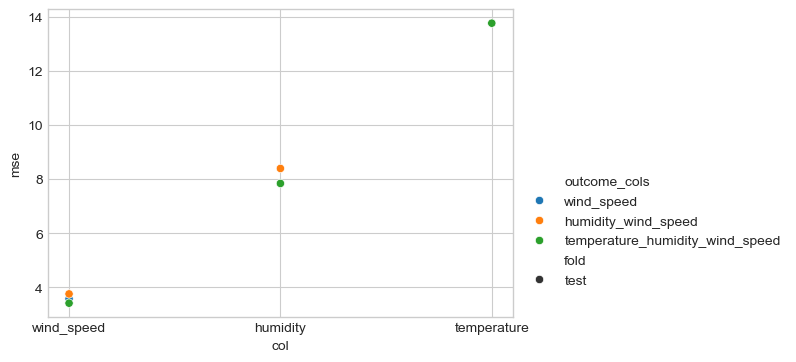

In [7]:
fig, ax = plt.subplots(figsize=(6, 4))
sns.scatterplot(
    data=losses.filter(pl.col("fold") == "test"),
    x="col",
    y="mse",
    hue="outcome_cols",
    style="fold",
    ax=ax,
)
ax.legend(loc="upper left", bbox_to_anchor=(1, 0.5))
fig.show()

### Wider network

How does layer size/architecture relate to performance improvements?

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/stantoon/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:108: PossibleUserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn(
/Users/stantoon/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/Users/stantoon/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/pytorch_lightning/trainer/trainer.py:1609: PossibleUserWarning: The number of training batches (1) is s

Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=200` reached.
/var/folders/_v/nlh4h1yx2n1gd6f3szjlgxt40000gr/T/ipykernel_20630/2492728506.py:33: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/var/folders/_v/nlh4h1yx2n1gd6f3szjlgxt40000gr/T/ipykernel_20630/2492728506.py:69: DeprecationWarning: `DataFrame.melt` is deprecated. Use `unpivot` instead, with `index` instead of `id_vars` and `on` instead of `value_vars`
  data=df_train_est.melt(
/var/folders/_v/nlh4h1yx2n1gd6f3szjlgxt40000gr/T/ipykernel_20630/2492728506.py:78: DeprecationWarning: `DataFrame.melt` is deprecated. Use `unpivot` instead, with `index` instead of `id_vars` and `on` instead of `value_vars`
  data=df_test_est.melt(
/var/folders/_v/nlh4h1yx2n1gd6f3szjlgxt40000gr/T/ipykernel_20630/2492728506.py:69: DeprecationWarning: `DataFrame.melt` is deprecated. Use `unpivot` instead, with `index` instead of `id_vars` and `on` instead of `value_vars`
  data=df_train_est.melt(
/var/folders/_v/nlh4h1yx2n1gd

outcome_cols,fold,col,mse
str,str,str,f64
"""humidity_wind_speed""","""test""","""wind_speed""",5.372828
"""temperature_humidity_wind_spee…","""test""","""wind_speed""",4.309397
"""wind_speed""","""test""","""wind_speed""",5.155591
"""humidity_wind_speed""","""train""","""wind_speed""",0.859944
"""temperature_humidity_wind_spee…","""train""","""wind_speed""",1.301318
"""wind_speed""","""train""","""wind_speed""",0.81463


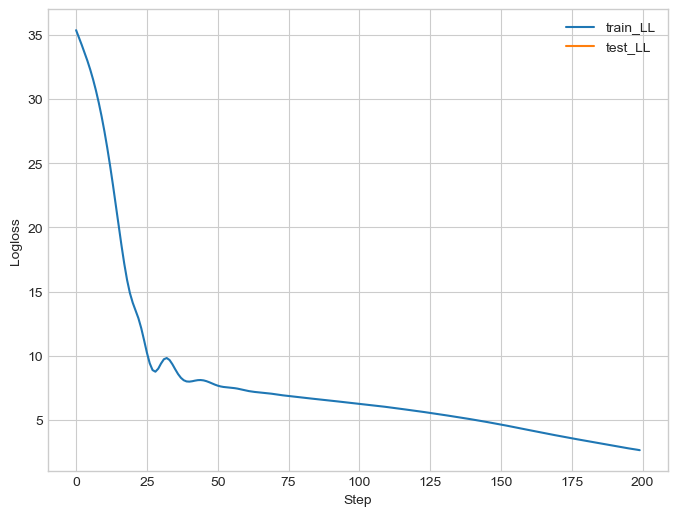

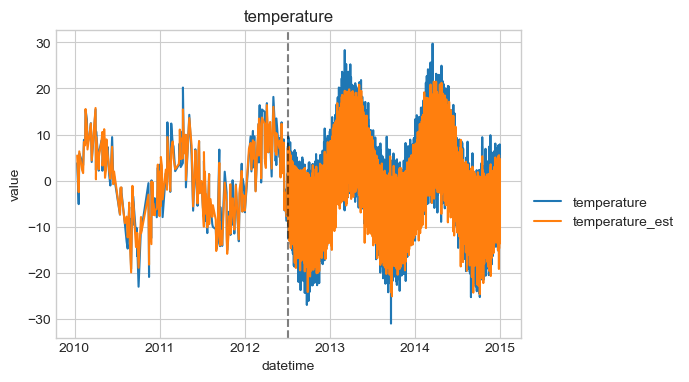

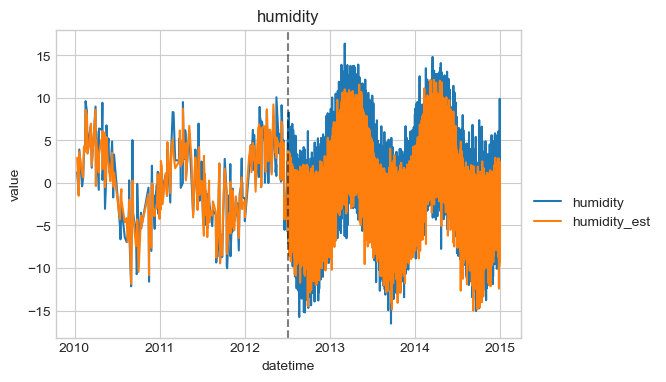

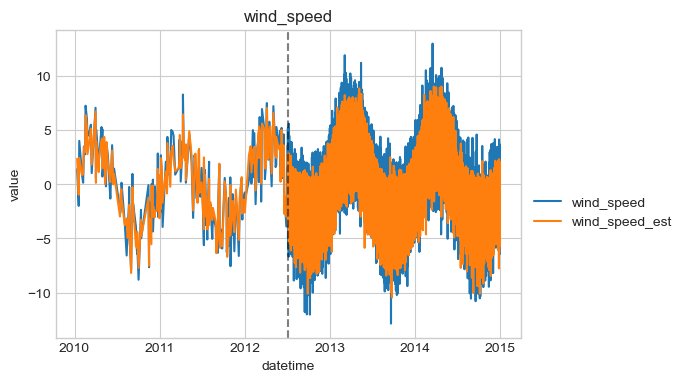

In [8]:
outcome_groups = [
    ["wind_speed"],
    ["humidity", "wind_speed"],
    ["temperature", "humidity", "wind_speed"],
]
losses = []
for outcome_cols in outcome_groups:
    loss_train, loss_test = loss_from_outcomes(
        outcome_cols=outcome_cols,
        model_callable=lambda feature_cols, outcome_cols: SimpleMLP(
            input_dim=len(feature_cols),
            output_dim=len(outcome_cols),
            learning_rate=1e-3,
            hidden_dim=[128, 64, 32, 16],
        ),
        debug=len(outcome_cols)==3,
    )
    losses.extend(
        [
            {"outcome_cols": "_".join(outcome_cols), "fold": "train", **loss}
            for loss in loss_train
        ]
    )
    losses.extend(
        [
            {"outcome_cols": "_".join(outcome_cols), "fold": "test", **loss}
            for loss in loss_test
        ]
    )

losses = pl.DataFrame(losses)
losses.sort(["col", "fold", "outcome_cols"]).filter(pl.col("col") == "wind_speed")

/var/folders/_v/nlh4h1yx2n1gd6f3szjlgxt40000gr/T/ipykernel_20630/3731575569.py:11: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


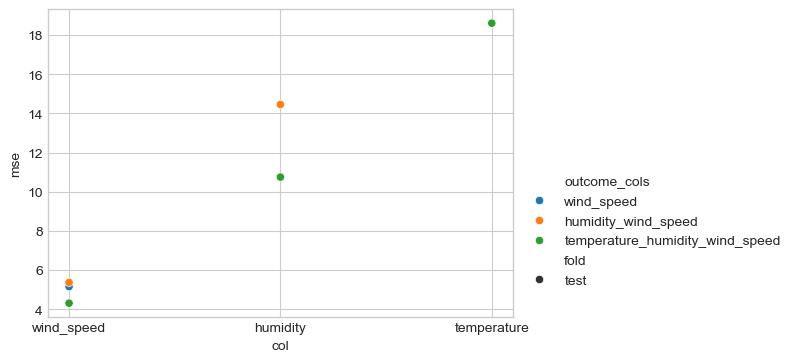

In [9]:
fig, ax = plt.subplots(figsize=(6, 4))
sns.scatterplot(
    data=losses.filter(pl.col("fold") == "test"),
    x="col",
    y="mse",
    hue="outcome_cols",
    style="fold",
    ax=ax,
)
ax.legend(loc="upper left", bbox_to_anchor=(1, 0.5))
fig.show()

With a larger network including temperature and humidity makes test performance marginally better. Including humidity made it worse.

### Output weighting

The above networks evenly weight the mean squared error across all outcomes.
If a single outcome has a larger range than others this will bias the error towards it.
We can solve this by making a weighted average over the MSE from each outcome.

In [10]:
class OutputWeightedMLP(SimpleMLP):
    def __init__(
        self,
        output_weighting: List[float] = None,
        output_dim: int = 1,
        **kwargs,
    ):
        if output_weighting is None:
            output_weighting = [1 / output_dim] * output_dim
        self.output_weighting = output_weighting
        self.output_dim = output_dim

        super().__init__(output_dim=output_dim, **kwargs)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_est = self.forward(x)

        loss = sum(
            [
                self.output_weighting[idx] * self.loss(y[:, idx], y_est[:, idx])
                for idx in range(self.output_dim)
            ]
        )

        self.log("train_loss", loss, prog_bar=True, on_step=True)
        self.log_train.append(loss.detach().cpu().numpy())
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_est = self.forward(x)

        loss = sum(
            [
                self.output_weighting[idx] * self.loss(y[:, idx], y_est[:, idx])
                for idx in range(self.output_dim)
            ]
        )

        self.log("val_loss", loss, prog_bar=True, on_step=True)
        self.log_val.append(loss.cpu().numpy())
        return loss

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/stantoon/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:108: PossibleUserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn(

  | Name | Type       | Params
------------------------------------
0 | net  | Sequential | 1.9 K 
1 | loss | MSELoss    | 0     
------------------------------------
1.9 K     Trainable params
0         Non-trainable params
1.9 K     Total params
0.008     Total estimated model params size (MB)
/Users/stantoon/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argumen

Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=200` reached.
/var/folders/_v/nlh4h1yx2n1gd6f3szjlgxt40000gr/T/ipykernel_20630/2492728506.py:33: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/var/folders/_v/nlh4h1yx2n1gd6f3szjlgxt40000gr/T/ipykernel_20630/2492728506.py:69: DeprecationWarning: `DataFrame.melt` is deprecated. Use `unpivot` instead, with `index` instead of `id_vars` and `on` instead of `value_vars`
  data=df_train_est.melt(
/var/folders/_v/nlh4h1yx2n1gd6f3szjlgxt40000gr/T/ipykernel_20630/2492728506.py:78: DeprecationWarning: `DataFrame.melt` is deprecated. Use `unpivot` instead, with `index` instead of `id_vars` and `on` instead of `value_vars`
  data=df_test_est.melt(
/var/folders/_v/nlh4h1yx2n1gd6f3szjlgxt40000gr/T/ipykernel_20630/2492728506.py:69: DeprecationWarning: `DataFrame.melt` is deprecated. Use `unpivot` instead, with `index` instead of `id_vars` and `on` instead of `value_vars`
  data=df_train_est.melt(
/var/folders/_v/nlh4h1yx2n1gd

outcome_cols,output_weighting,fold,col,mse
str,str,str,str,f64
"""wind_speed_humidity_temperatur…","""[0.1, 0.1, 0.8]""","""test""","""wind_speed""",3.211164
"""wind_speed_humidity_temperatur…","""[0.3333333333333333, 0.3333333…","""test""","""wind_speed""",3.299351
"""wind_speed_humidity_temperatur…","""[0.8, 0.1, 0.1]""","""test""","""wind_speed""",3.398079
"""wind_speed_humidity_temperatur…","""[0.1, 0.1, 0.8]""","""train""","""wind_speed""",2.907289
"""wind_speed_humidity_temperatur…","""[0.3333333333333333, 0.3333333…","""train""","""wind_speed""",2.72603
"""wind_speed_humidity_temperatur…","""[0.8, 0.1, 0.1]""","""train""","""wind_speed""",2.552484


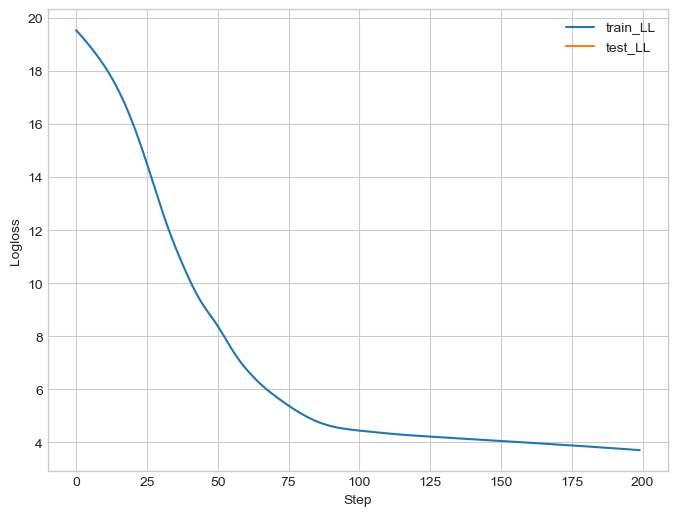

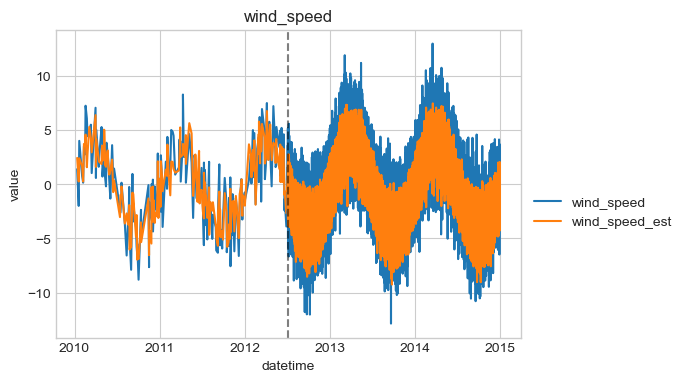

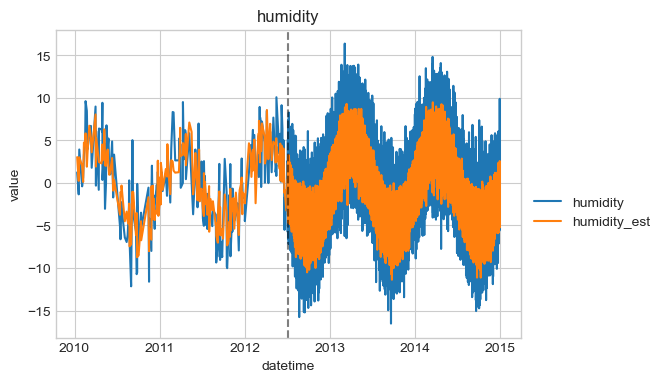

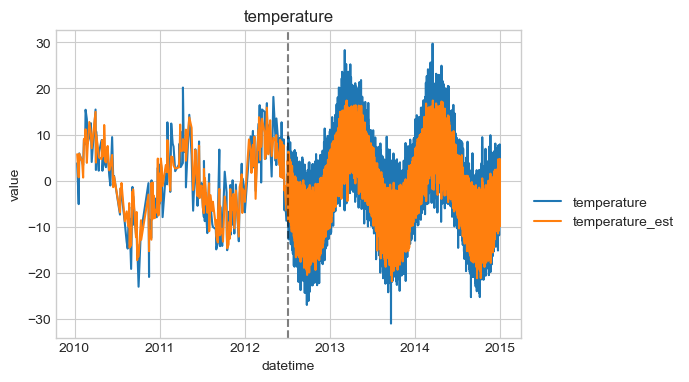

In [11]:
outcome_cols = ["wind_speed", "humidity", "temperature"]
weighting_groups = [[0.8, 0.1, 0.1], [1/3, 1/3, 1/3], [0.1, 0.1, 0.8]]
losses = []
for output_weighting in weighting_groups:
    loss_train, loss_test = loss_from_outcomes(
        outcome_cols=outcome_cols,
        model_callable=lambda feature_cols, outcome_cols: OutputWeightedMLP(
            input_dim=len(feature_cols),
            output_dim=len(outcome_cols),
            learning_rate=1e-3,
            output_weighting=output_weighting,
        ),
        debug=[0.8, 0.1, 0.1]==output_weighting,
    )
    losses.extend(
        [
            {
                "outcome_cols": "_".join(outcome_cols),
                "output_weighting": str(output_weighting),
                "fold": "train",
                **loss,
            }
            for loss in loss_train
        ]
    )
    losses.extend(
        [
            {
                "outcome_cols": "_".join(outcome_cols),
                "output_weighting": str(output_weighting),
                "fold": "test",
                **loss,
            }
            for loss in loss_test
        ]
    )

losses = pl.DataFrame(losses)
losses.sort(["col", "fold", "outcome_cols", "output_weighting"]).filter(
    pl.col("col") == "wind_speed"
)

/var/folders/_v/nlh4h1yx2n1gd6f3szjlgxt40000gr/T/ipykernel_20630/3580397801.py:11: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


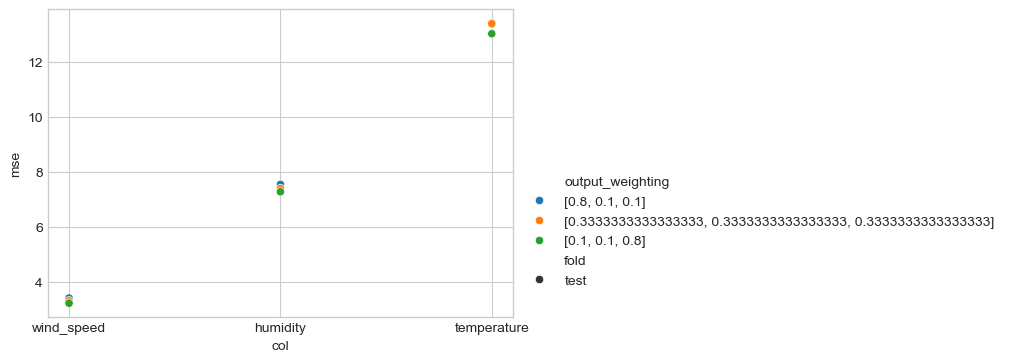

In [12]:
fig, ax = plt.subplots(figsize=(6, 4))
sns.scatterplot(
    data=losses.filter(pl.col("fold") == "test"),
    x="col",
    y="mse",
    hue="output_weighting",
    style="fold",
    ax=ax,
)
ax.legend(loc="upper left", bbox_to_anchor=(1, 0.5))
fig.show()

Reweighting the output losses doesn't make a large difference here.
The outcomes have similar scales so the losses are not too uneven.
Its likely that the network can solve for all of them given a reasonable weighting.

### Separate output heads

We can give more representation to the separation between tasks by having separate heads for each task.
We have some shared layers (denoted as an encoder) which feed into each task head.

In [13]:
class OutputHeadsMLP(pyl.LightningModule):
    def __init__(
        self,
        input_dim: int,
        hidden_dim: List[int] = None,
        output_dim: int = 1,
        learning_rate=1e-3,
    ):
        super().__init__()

        if hidden_dim is None:
            hidden_dim = [32, 16, 16, 16]

        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim[0]),
            nn.ReLU(),
            nn.Linear(hidden_dim[0], hidden_dim[1]),
            nn.ReLU(),
            nn.Linear(hidden_dim[1], hidden_dim[2]),
            nn.ReLU(),
            nn.Linear(hidden_dim[2], hidden_dim[3]),
        )
        self.output_layers = nn.ModuleList(
            [nn.Linear(hidden_dim[3], 1) for _ in range(output_dim)]
        )
        self.loss = nn.MSELoss()
        self.log_train = []
        self.log_val = []
        self.learning_rate = learning_rate

    def forward(self, x):
        emb = self.encoder(x)
        outputs = [output_layer(emb) for output_layer in self.output_layers]
        return torch.concat(outputs, dim=1)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(
            self.parameters(),
            lr=self.learning_rate,
        )
        return optimizer

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_est = self.forward(x)
        loss = self.loss(y, y_est)  # averages over all outcomes equally

        self.log("train_loss", loss, prog_bar=True, on_step=True)
        self.log_train.append(loss.detach().cpu().numpy())
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_est = self.forward(x)
        loss = self.loss(y, y_est)

        self.log("val_loss", loss, prog_bar=True, on_step=True)
        self.log_val.append(loss.cpu().numpy())
        return loss

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/stantoon/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:108: PossibleUserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn(
/Users/stantoon/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/Users/stantoon/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/pytorch_lightning/trainer/trainer.py:1609: PossibleUserWarning: The number of training batches (1) is s

Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=200` reached.
/var/folders/_v/nlh4h1yx2n1gd6f3szjlgxt40000gr/T/ipykernel_20630/2492728506.py:33: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/var/folders/_v/nlh4h1yx2n1gd6f3szjlgxt40000gr/T/ipykernel_20630/2492728506.py:69: DeprecationWarning: `DataFrame.melt` is deprecated. Use `unpivot` instead, with `index` instead of `id_vars` and `on` instead of `value_vars`
  data=df_train_est.melt(
/var/folders/_v/nlh4h1yx2n1gd6f3szjlgxt40000gr/T/ipykernel_20630/2492728506.py:78: DeprecationWarning: `DataFrame.melt` is deprecated. Use `unpivot` instead, with `index` instead of `id_vars` and `on` instead of `value_vars`
  data=df_test_est.melt(
/var/folders/_v/nlh4h1yx2n1gd6f3szjlgxt40000gr/T/ipykernel_20630/2492728506.py:69: DeprecationWarning: `DataFrame.melt` is deprecated. Use `unpivot` instead, with `index` instead of `id_vars` and `on` instead of `value_vars`
  data=df_train_est.melt(
/var/folders/_v/nlh4h1yx2n1gd

outcome_cols,fold,col,mse
str,str,str,f64
"""humidity_wind_speed""","""test""","""wind_speed""",3.754012
"""temperature_humidity_wind_spee…","""test""","""wind_speed""",3.323928
"""wind_speed""","""test""","""wind_speed""",3.575849
"""humidity_wind_speed""","""train""","""wind_speed""",2.537587
"""temperature_humidity_wind_spee…","""train""","""wind_speed""",2.667841
"""wind_speed""","""train""","""wind_speed""",2.734326


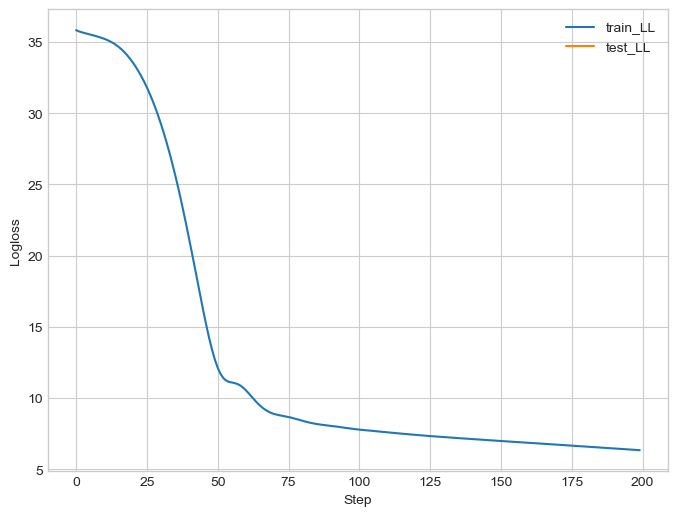

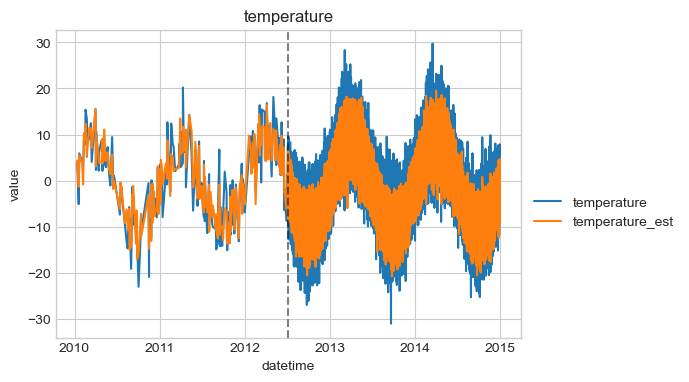

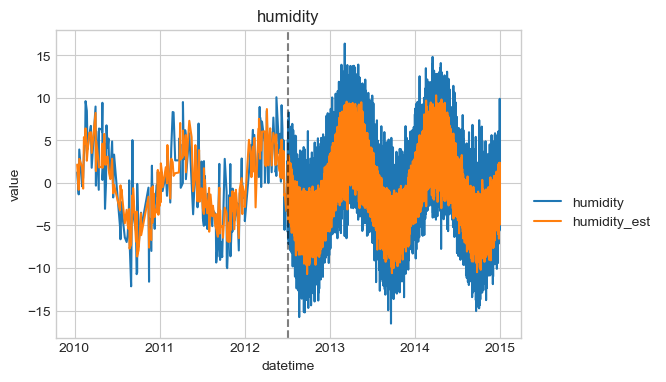

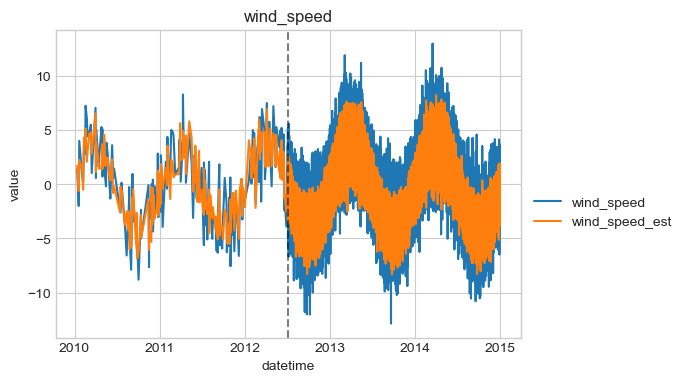

In [14]:
outcome_groups = [
    ["wind_speed"],
    ["humidity", "wind_speed"],
    ["temperature", "humidity", "wind_speed"],
]
losses = []
for outcome_cols in outcome_groups:
    loss_train, loss_test = loss_from_outcomes(
        outcome_cols=outcome_cols,
        model_callable=lambda feature_cols, outcome_cols: OutputHeadsMLP(
            input_dim=len(feature_cols),
            output_dim=len(outcome_cols),
            learning_rate=1e-3,
        ),
        debug=len(outcome_cols)==3,
    )
    losses.extend(
        [
            {"outcome_cols": "_".join(outcome_cols), "fold": "train", **loss}
            for loss in loss_train
        ]
    )
    losses.extend(
        [
            {"outcome_cols": "_".join(outcome_cols), "fold": "test", **loss}
            for loss in loss_test
        ]
    )

losses = pl.DataFrame(losses)
losses.sort(["col", "fold", "outcome_cols"]).filter(pl.col("col") == "wind_speed")

/var/folders/_v/nlh4h1yx2n1gd6f3szjlgxt40000gr/T/ipykernel_20630/3731575569.py:11: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


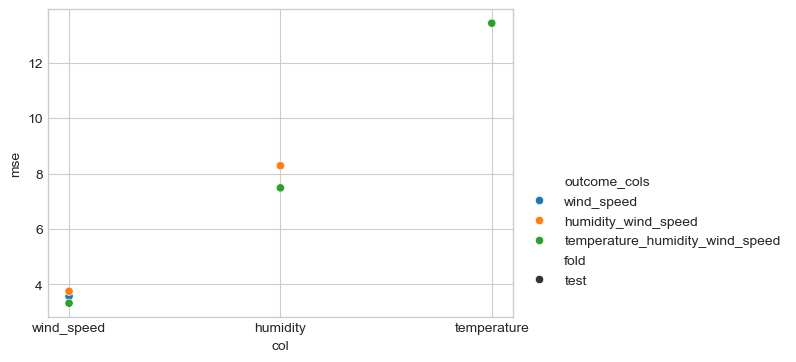

In [15]:
fig, ax = plt.subplots(figsize=(6, 4))
sns.scatterplot(
    data=losses.filter(pl.col("fold") == "test"),
    x="col",
    y="mse",
    hue="outcome_cols",
    style="fold",
    ax=ax,
)
ax.legend(loc="upper left", bbox_to_anchor=(1, 0.5))
fig.show()

## Repeated trials

We repeat the trials over a range of random seeds to get a better sense of performance

Setup all our test cases (15mins)

In [16]:
outcome_feature_combinations = [
    {
        "outcome_cols": ["temperature"],
        "feature_cols": ["temperature"],
        "model_name": "single outcome, single feature",
        "callable": lambda feature_cols, outcome_cols: SimpleMLP(
            input_dim=len(feature_cols),
            output_dim=len(outcome_cols),
            learning_rate=1e-3,
        ),
    },
    {
        "outcome_cols": ["temperature"],
        "feature_cols": ["temperature", "humidity", "wind_speed"],
        "model_name": "single outcome, all features",
        "callable": lambda feature_cols, outcome_cols: SimpleMLP(
            input_dim=len(feature_cols),
            output_dim=len(outcome_cols),
            learning_rate=1e-3,
        ),
    },
    {
        "outcome_cols": ["humidity"],
        "feature_cols": ["humidity"],
        "model_name": "single outcome, single feature",
        "callable": lambda feature_cols, outcome_cols: SimpleMLP(
            input_dim=len(feature_cols),
            output_dim=len(outcome_cols),
            learning_rate=1e-3,
        ),
    },
    {
        "outcome_cols": ["humidity"],
        "feature_cols": ["temperature", "humidity", "wind_speed"],
        "model_name": "single outcome, all features",
        "callable": lambda feature_cols, outcome_cols: SimpleMLP(
            input_dim=len(feature_cols),
            output_dim=len(outcome_cols),
            learning_rate=1e-3,
        ),
    },
    {
        "outcome_cols": ["wind_speed"],
        "feature_cols": ["wind_speed"],
        "model_name": "single outcome, single feature",
        "callable": lambda feature_cols, outcome_cols: SimpleMLP(
            input_dim=len(feature_cols),
            output_dim=len(outcome_cols),
            learning_rate=1e-3,
        ),
    },
    {
        "outcome_cols": ["wind_speed"],
        "feature_cols": ["temperature", "humidity", "wind_speed"],
        "model_name": "single outcome, all features",
        "callable": lambda feature_cols, outcome_cols: SimpleMLP(
            input_dim=len(feature_cols),
            output_dim=len(outcome_cols),
            learning_rate=1e-3,
        ),
    },
    {
        "outcome_cols": ["temperature", "humidity", "wind_speed"],
        "feature_cols": ["temperature", "humidity", "wind_speed"],
        "model_name": "all outcomes, all features",
        "callable": lambda feature_cols, outcome_cols: SimpleMLP(
            input_dim=len(feature_cols),
            output_dim=len(outcome_cols),
            learning_rate=1e-3,
        ),
    },
    {
        "outcome_cols": ["temperature", "humidity", "wind_speed"],
        "feature_cols": ["temperature", "humidity", "wind_speed"],
        "model_name": "all outcomes, all features, multi-head",
        "callable": lambda feature_cols, outcome_cols: OutputHeadsMLP(
            input_dim=len(feature_cols),
            output_dim=len(outcome_cols),
            learning_rate=1e-3,
        ),
    },
    {
        "outcome_cols": ["temperature", "humidity", "wind_speed"],
        "feature_cols": ["temperature", "humidity", "wind_speed"],
        "model_name": "all outcomes, all features, weighted-wind speed",
        "callable": lambda feature_cols, outcome_cols: OutputWeightedMLP(
            input_dim=len(feature_cols),
            output_dim=len(outcome_cols),
            learning_rate=1e-3,
            output_weighting=[0.1, 0.1, 0.8],
        ),
    },
]

In [17]:
lags = [1, 2, 5, 10, 24, 48, 72, 96]
losses = []
for seed in range(20):
    print(f"running seed {seed}")
    df = generate_data(seed=seed)
    df_lagged = create_lags(df, columns=df.columns[1:], lags=lags)

    df_train = df_lagged[: int(df_lagged.shape[0] * 0.5)].sample(fraction=0.01, seed=0)
    df_test = df_lagged[int(df_lagged.shape[0] * 0.5) :]

    for combination in outcome_feature_combinations:
        outcome_cols = combination["outcome_cols"]
        feature_cols = combination["feature_cols"]
        print(f"outcome_cols: {outcome_cols}, feature_cols: {feature_cols}")

        loss_train, loss_test = loss_from_outcomes(
            outcome_cols=outcome_cols,
            feature_cols=get_features_from_outcomes(df_train, feature_cols),
            model_callable=combination["callable"],
            df_train=df_train,
            df_test=df_test,
            debug=False,
        )

        losses.extend(
            [
                {
                    "model_name": combination["model_name"],
                    "outcome_cols": "_".join(outcome_cols),
                    "feature_cols": "_".join(feature_cols),
                    "seed": seed,
                    "fold": "train",
                    **loss,
                }
                for loss in loss_train
            ]
        )
        losses.extend(
            [
                {
                    "model_name": combination["model_name"],
                    "outcome_cols": "_".join(outcome_cols),
                    "feature_cols": "_".join(feature_cols),
                    "seed": seed,
                    "fold": "test",
                    **loss,
                }
                for loss in loss_test
            ]
        )

losses_repeat_trials = pl.DataFrame(losses)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


running seed 0
outcome_cols: ['temperature'], feature_cols: ['temperature']


/Users/stantoon/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:108: PossibleUserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn(
/Users/stantoon/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/Users/stantoon/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/pytorch_lightning/trainer/trainer.py:1609: PossibleUserWarning: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.

outcome_cols: ['temperature'], feature_cols: ['temperature', 'humidity', 'wind_speed']


`Trainer.fit` stopped: `max_epochs=200` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


outcome_cols: ['humidity'], feature_cols: ['humidity']


`Trainer.fit` stopped: `max_epochs=200` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


outcome_cols: ['humidity'], feature_cols: ['temperature', 'humidity', 'wind_speed']


`Trainer.fit` stopped: `max_epochs=200` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


outcome_cols: ['wind_speed'], feature_cols: ['wind_speed']


`Trainer.fit` stopped: `max_epochs=200` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


outcome_cols: ['wind_speed'], feature_cols: ['temperature', 'humidity', 'wind_speed']


`Trainer.fit` stopped: `max_epochs=200` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


outcome_cols: ['temperature', 'humidity', 'wind_speed'], feature_cols: ['temperature', 'humidity', 'wind_speed']


`Trainer.fit` stopped: `max_epochs=200` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


outcome_cols: ['temperature', 'humidity', 'wind_speed'], feature_cols: ['temperature', 'humidity', 'wind_speed']


`Trainer.fit` stopped: `max_epochs=200` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


outcome_cols: ['temperature', 'humidity', 'wind_speed'], feature_cols: ['temperature', 'humidity', 'wind_speed']


`Trainer.fit` stopped: `max_epochs=200` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


running seed 1
outcome_cols: ['temperature'], feature_cols: ['temperature']


`Trainer.fit` stopped: `max_epochs=200` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


outcome_cols: ['temperature'], feature_cols: ['temperature', 'humidity', 'wind_speed']


`Trainer.fit` stopped: `max_epochs=200` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


outcome_cols: ['humidity'], feature_cols: ['humidity']


`Trainer.fit` stopped: `max_epochs=200` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


outcome_cols: ['humidity'], feature_cols: ['temperature', 'humidity', 'wind_speed']


`Trainer.fit` stopped: `max_epochs=200` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


outcome_cols: ['wind_speed'], feature_cols: ['wind_speed']


`Trainer.fit` stopped: `max_epochs=200` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


outcome_cols: ['wind_speed'], feature_cols: ['temperature', 'humidity', 'wind_speed']


`Trainer.fit` stopped: `max_epochs=200` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


outcome_cols: ['temperature', 'humidity', 'wind_speed'], feature_cols: ['temperature', 'humidity', 'wind_speed']


`Trainer.fit` stopped: `max_epochs=200` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


outcome_cols: ['temperature', 'humidity', 'wind_speed'], feature_cols: ['temperature', 'humidity', 'wind_speed']


`Trainer.fit` stopped: `max_epochs=200` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


outcome_cols: ['temperature', 'humidity', 'wind_speed'], feature_cols: ['temperature', 'humidity', 'wind_speed']


`Trainer.fit` stopped: `max_epochs=200` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


running seed 2
outcome_cols: ['temperature'], feature_cols: ['temperature']


`Trainer.fit` stopped: `max_epochs=200` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


outcome_cols: ['temperature'], feature_cols: ['temperature', 'humidity', 'wind_speed']


`Trainer.fit` stopped: `max_epochs=200` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


outcome_cols: ['humidity'], feature_cols: ['humidity']


`Trainer.fit` stopped: `max_epochs=200` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


outcome_cols: ['humidity'], feature_cols: ['temperature', 'humidity', 'wind_speed']


`Trainer.fit` stopped: `max_epochs=200` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


outcome_cols: ['wind_speed'], feature_cols: ['wind_speed']


`Trainer.fit` stopped: `max_epochs=200` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


outcome_cols: ['wind_speed'], feature_cols: ['temperature', 'humidity', 'wind_speed']


`Trainer.fit` stopped: `max_epochs=200` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


outcome_cols: ['temperature', 'humidity', 'wind_speed'], feature_cols: ['temperature', 'humidity', 'wind_speed']


`Trainer.fit` stopped: `max_epochs=200` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


outcome_cols: ['temperature', 'humidity', 'wind_speed'], feature_cols: ['temperature', 'humidity', 'wind_speed']


`Trainer.fit` stopped: `max_epochs=200` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


outcome_cols: ['temperature', 'humidity', 'wind_speed'], feature_cols: ['temperature', 'humidity', 'wind_speed']


`Trainer.fit` stopped: `max_epochs=200` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


running seed 3
outcome_cols: ['temperature'], feature_cols: ['temperature']


`Trainer.fit` stopped: `max_epochs=200` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


outcome_cols: ['temperature'], feature_cols: ['temperature', 'humidity', 'wind_speed']


`Trainer.fit` stopped: `max_epochs=200` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


outcome_cols: ['humidity'], feature_cols: ['humidity']


`Trainer.fit` stopped: `max_epochs=200` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


outcome_cols: ['humidity'], feature_cols: ['temperature', 'humidity', 'wind_speed']


`Trainer.fit` stopped: `max_epochs=200` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


outcome_cols: ['wind_speed'], feature_cols: ['wind_speed']


`Trainer.fit` stopped: `max_epochs=200` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


outcome_cols: ['wind_speed'], feature_cols: ['temperature', 'humidity', 'wind_speed']


`Trainer.fit` stopped: `max_epochs=200` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


outcome_cols: ['temperature', 'humidity', 'wind_speed'], feature_cols: ['temperature', 'humidity', 'wind_speed']


`Trainer.fit` stopped: `max_epochs=200` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


outcome_cols: ['temperature', 'humidity', 'wind_speed'], feature_cols: ['temperature', 'humidity', 'wind_speed']


`Trainer.fit` stopped: `max_epochs=200` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


outcome_cols: ['temperature', 'humidity', 'wind_speed'], feature_cols: ['temperature', 'humidity', 'wind_speed']


`Trainer.fit` stopped: `max_epochs=200` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


running seed 4
outcome_cols: ['temperature'], feature_cols: ['temperature']


`Trainer.fit` stopped: `max_epochs=200` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


outcome_cols: ['temperature'], feature_cols: ['temperature', 'humidity', 'wind_speed']


`Trainer.fit` stopped: `max_epochs=200` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


outcome_cols: ['humidity'], feature_cols: ['humidity']


`Trainer.fit` stopped: `max_epochs=200` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


outcome_cols: ['humidity'], feature_cols: ['temperature', 'humidity', 'wind_speed']


`Trainer.fit` stopped: `max_epochs=200` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


outcome_cols: ['wind_speed'], feature_cols: ['wind_speed']


`Trainer.fit` stopped: `max_epochs=200` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


outcome_cols: ['wind_speed'], feature_cols: ['temperature', 'humidity', 'wind_speed']


`Trainer.fit` stopped: `max_epochs=200` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


outcome_cols: ['temperature', 'humidity', 'wind_speed'], feature_cols: ['temperature', 'humidity', 'wind_speed']


`Trainer.fit` stopped: `max_epochs=200` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


outcome_cols: ['temperature', 'humidity', 'wind_speed'], feature_cols: ['temperature', 'humidity', 'wind_speed']


`Trainer.fit` stopped: `max_epochs=200` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


outcome_cols: ['temperature', 'humidity', 'wind_speed'], feature_cols: ['temperature', 'humidity', 'wind_speed']


`Trainer.fit` stopped: `max_epochs=200` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


running seed 5
outcome_cols: ['temperature'], feature_cols: ['temperature']


`Trainer.fit` stopped: `max_epochs=200` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


outcome_cols: ['temperature'], feature_cols: ['temperature', 'humidity', 'wind_speed']


`Trainer.fit` stopped: `max_epochs=200` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


outcome_cols: ['humidity'], feature_cols: ['humidity']


`Trainer.fit` stopped: `max_epochs=200` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


outcome_cols: ['humidity'], feature_cols: ['temperature', 'humidity', 'wind_speed']


`Trainer.fit` stopped: `max_epochs=200` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


outcome_cols: ['wind_speed'], feature_cols: ['wind_speed']


`Trainer.fit` stopped: `max_epochs=200` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


outcome_cols: ['wind_speed'], feature_cols: ['temperature', 'humidity', 'wind_speed']


`Trainer.fit` stopped: `max_epochs=200` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


outcome_cols: ['temperature', 'humidity', 'wind_speed'], feature_cols: ['temperature', 'humidity', 'wind_speed']


`Trainer.fit` stopped: `max_epochs=200` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


outcome_cols: ['temperature', 'humidity', 'wind_speed'], feature_cols: ['temperature', 'humidity', 'wind_speed']


`Trainer.fit` stopped: `max_epochs=200` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


outcome_cols: ['temperature', 'humidity', 'wind_speed'], feature_cols: ['temperature', 'humidity', 'wind_speed']


`Trainer.fit` stopped: `max_epochs=200` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


running seed 6
outcome_cols: ['temperature'], feature_cols: ['temperature']


`Trainer.fit` stopped: `max_epochs=200` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


outcome_cols: ['temperature'], feature_cols: ['temperature', 'humidity', 'wind_speed']


`Trainer.fit` stopped: `max_epochs=200` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


outcome_cols: ['humidity'], feature_cols: ['humidity']


`Trainer.fit` stopped: `max_epochs=200` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


outcome_cols: ['humidity'], feature_cols: ['temperature', 'humidity', 'wind_speed']


`Trainer.fit` stopped: `max_epochs=200` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


outcome_cols: ['wind_speed'], feature_cols: ['wind_speed']


`Trainer.fit` stopped: `max_epochs=200` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


outcome_cols: ['wind_speed'], feature_cols: ['temperature', 'humidity', 'wind_speed']


`Trainer.fit` stopped: `max_epochs=200` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


outcome_cols: ['temperature', 'humidity', 'wind_speed'], feature_cols: ['temperature', 'humidity', 'wind_speed']


`Trainer.fit` stopped: `max_epochs=200` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


outcome_cols: ['temperature', 'humidity', 'wind_speed'], feature_cols: ['temperature', 'humidity', 'wind_speed']


`Trainer.fit` stopped: `max_epochs=200` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


outcome_cols: ['temperature', 'humidity', 'wind_speed'], feature_cols: ['temperature', 'humidity', 'wind_speed']


`Trainer.fit` stopped: `max_epochs=200` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


running seed 7
outcome_cols: ['temperature'], feature_cols: ['temperature']


`Trainer.fit` stopped: `max_epochs=200` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


outcome_cols: ['temperature'], feature_cols: ['temperature', 'humidity', 'wind_speed']


`Trainer.fit` stopped: `max_epochs=200` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


outcome_cols: ['humidity'], feature_cols: ['humidity']


`Trainer.fit` stopped: `max_epochs=200` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


outcome_cols: ['humidity'], feature_cols: ['temperature', 'humidity', 'wind_speed']


`Trainer.fit` stopped: `max_epochs=200` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


outcome_cols: ['wind_speed'], feature_cols: ['wind_speed']


`Trainer.fit` stopped: `max_epochs=200` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


outcome_cols: ['wind_speed'], feature_cols: ['temperature', 'humidity', 'wind_speed']


`Trainer.fit` stopped: `max_epochs=200` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


outcome_cols: ['temperature', 'humidity', 'wind_speed'], feature_cols: ['temperature', 'humidity', 'wind_speed']


`Trainer.fit` stopped: `max_epochs=200` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


outcome_cols: ['temperature', 'humidity', 'wind_speed'], feature_cols: ['temperature', 'humidity', 'wind_speed']


`Trainer.fit` stopped: `max_epochs=200` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


outcome_cols: ['temperature', 'humidity', 'wind_speed'], feature_cols: ['temperature', 'humidity', 'wind_speed']


`Trainer.fit` stopped: `max_epochs=200` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


running seed 8
outcome_cols: ['temperature'], feature_cols: ['temperature']


`Trainer.fit` stopped: `max_epochs=200` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


outcome_cols: ['temperature'], feature_cols: ['temperature', 'humidity', 'wind_speed']


`Trainer.fit` stopped: `max_epochs=200` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


outcome_cols: ['humidity'], feature_cols: ['humidity']


`Trainer.fit` stopped: `max_epochs=200` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


outcome_cols: ['humidity'], feature_cols: ['temperature', 'humidity', 'wind_speed']


`Trainer.fit` stopped: `max_epochs=200` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


outcome_cols: ['wind_speed'], feature_cols: ['wind_speed']


`Trainer.fit` stopped: `max_epochs=200` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


outcome_cols: ['wind_speed'], feature_cols: ['temperature', 'humidity', 'wind_speed']


`Trainer.fit` stopped: `max_epochs=200` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


outcome_cols: ['temperature', 'humidity', 'wind_speed'], feature_cols: ['temperature', 'humidity', 'wind_speed']


`Trainer.fit` stopped: `max_epochs=200` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


outcome_cols: ['temperature', 'humidity', 'wind_speed'], feature_cols: ['temperature', 'humidity', 'wind_speed']


`Trainer.fit` stopped: `max_epochs=200` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


outcome_cols: ['temperature', 'humidity', 'wind_speed'], feature_cols: ['temperature', 'humidity', 'wind_speed']


`Trainer.fit` stopped: `max_epochs=200` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


running seed 9
outcome_cols: ['temperature'], feature_cols: ['temperature']


`Trainer.fit` stopped: `max_epochs=200` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


outcome_cols: ['temperature'], feature_cols: ['temperature', 'humidity', 'wind_speed']


`Trainer.fit` stopped: `max_epochs=200` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


outcome_cols: ['humidity'], feature_cols: ['humidity']


`Trainer.fit` stopped: `max_epochs=200` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


outcome_cols: ['humidity'], feature_cols: ['temperature', 'humidity', 'wind_speed']


`Trainer.fit` stopped: `max_epochs=200` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


outcome_cols: ['wind_speed'], feature_cols: ['wind_speed']


`Trainer.fit` stopped: `max_epochs=200` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


outcome_cols: ['wind_speed'], feature_cols: ['temperature', 'humidity', 'wind_speed']


`Trainer.fit` stopped: `max_epochs=200` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


outcome_cols: ['temperature', 'humidity', 'wind_speed'], feature_cols: ['temperature', 'humidity', 'wind_speed']


`Trainer.fit` stopped: `max_epochs=200` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


outcome_cols: ['temperature', 'humidity', 'wind_speed'], feature_cols: ['temperature', 'humidity', 'wind_speed']


`Trainer.fit` stopped: `max_epochs=200` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


outcome_cols: ['temperature', 'humidity', 'wind_speed'], feature_cols: ['temperature', 'humidity', 'wind_speed']


`Trainer.fit` stopped: `max_epochs=200` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


running seed 10
outcome_cols: ['temperature'], feature_cols: ['temperature']


`Trainer.fit` stopped: `max_epochs=200` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


outcome_cols: ['temperature'], feature_cols: ['temperature', 'humidity', 'wind_speed']


`Trainer.fit` stopped: `max_epochs=200` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


outcome_cols: ['humidity'], feature_cols: ['humidity']


`Trainer.fit` stopped: `max_epochs=200` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


outcome_cols: ['humidity'], feature_cols: ['temperature', 'humidity', 'wind_speed']


`Trainer.fit` stopped: `max_epochs=200` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


outcome_cols: ['wind_speed'], feature_cols: ['wind_speed']


`Trainer.fit` stopped: `max_epochs=200` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


outcome_cols: ['wind_speed'], feature_cols: ['temperature', 'humidity', 'wind_speed']


`Trainer.fit` stopped: `max_epochs=200` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


outcome_cols: ['temperature', 'humidity', 'wind_speed'], feature_cols: ['temperature', 'humidity', 'wind_speed']


`Trainer.fit` stopped: `max_epochs=200` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


outcome_cols: ['temperature', 'humidity', 'wind_speed'], feature_cols: ['temperature', 'humidity', 'wind_speed']


`Trainer.fit` stopped: `max_epochs=200` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


outcome_cols: ['temperature', 'humidity', 'wind_speed'], feature_cols: ['temperature', 'humidity', 'wind_speed']


`Trainer.fit` stopped: `max_epochs=200` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


running seed 11
outcome_cols: ['temperature'], feature_cols: ['temperature']


`Trainer.fit` stopped: `max_epochs=200` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


outcome_cols: ['temperature'], feature_cols: ['temperature', 'humidity', 'wind_speed']


`Trainer.fit` stopped: `max_epochs=200` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


outcome_cols: ['humidity'], feature_cols: ['humidity']


`Trainer.fit` stopped: `max_epochs=200` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


outcome_cols: ['humidity'], feature_cols: ['temperature', 'humidity', 'wind_speed']


`Trainer.fit` stopped: `max_epochs=200` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


outcome_cols: ['wind_speed'], feature_cols: ['wind_speed']


`Trainer.fit` stopped: `max_epochs=200` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


outcome_cols: ['wind_speed'], feature_cols: ['temperature', 'humidity', 'wind_speed']


`Trainer.fit` stopped: `max_epochs=200` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


outcome_cols: ['temperature', 'humidity', 'wind_speed'], feature_cols: ['temperature', 'humidity', 'wind_speed']


`Trainer.fit` stopped: `max_epochs=200` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


outcome_cols: ['temperature', 'humidity', 'wind_speed'], feature_cols: ['temperature', 'humidity', 'wind_speed']


`Trainer.fit` stopped: `max_epochs=200` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


outcome_cols: ['temperature', 'humidity', 'wind_speed'], feature_cols: ['temperature', 'humidity', 'wind_speed']


`Trainer.fit` stopped: `max_epochs=200` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


running seed 12
outcome_cols: ['temperature'], feature_cols: ['temperature']


`Trainer.fit` stopped: `max_epochs=200` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


outcome_cols: ['temperature'], feature_cols: ['temperature', 'humidity', 'wind_speed']


`Trainer.fit` stopped: `max_epochs=200` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


outcome_cols: ['humidity'], feature_cols: ['humidity']


`Trainer.fit` stopped: `max_epochs=200` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


outcome_cols: ['humidity'], feature_cols: ['temperature', 'humidity', 'wind_speed']


`Trainer.fit` stopped: `max_epochs=200` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


outcome_cols: ['wind_speed'], feature_cols: ['wind_speed']


`Trainer.fit` stopped: `max_epochs=200` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


outcome_cols: ['wind_speed'], feature_cols: ['temperature', 'humidity', 'wind_speed']


`Trainer.fit` stopped: `max_epochs=200` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


outcome_cols: ['temperature', 'humidity', 'wind_speed'], feature_cols: ['temperature', 'humidity', 'wind_speed']


`Trainer.fit` stopped: `max_epochs=200` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


outcome_cols: ['temperature', 'humidity', 'wind_speed'], feature_cols: ['temperature', 'humidity', 'wind_speed']


`Trainer.fit` stopped: `max_epochs=200` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


outcome_cols: ['temperature', 'humidity', 'wind_speed'], feature_cols: ['temperature', 'humidity', 'wind_speed']


`Trainer.fit` stopped: `max_epochs=200` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


running seed 13
outcome_cols: ['temperature'], feature_cols: ['temperature']


`Trainer.fit` stopped: `max_epochs=200` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


outcome_cols: ['temperature'], feature_cols: ['temperature', 'humidity', 'wind_speed']


`Trainer.fit` stopped: `max_epochs=200` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


outcome_cols: ['humidity'], feature_cols: ['humidity']


`Trainer.fit` stopped: `max_epochs=200` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


outcome_cols: ['humidity'], feature_cols: ['temperature', 'humidity', 'wind_speed']


`Trainer.fit` stopped: `max_epochs=200` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


outcome_cols: ['wind_speed'], feature_cols: ['wind_speed']


`Trainer.fit` stopped: `max_epochs=200` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


outcome_cols: ['wind_speed'], feature_cols: ['temperature', 'humidity', 'wind_speed']


`Trainer.fit` stopped: `max_epochs=200` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


outcome_cols: ['temperature', 'humidity', 'wind_speed'], feature_cols: ['temperature', 'humidity', 'wind_speed']


`Trainer.fit` stopped: `max_epochs=200` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


outcome_cols: ['temperature', 'humidity', 'wind_speed'], feature_cols: ['temperature', 'humidity', 'wind_speed']


`Trainer.fit` stopped: `max_epochs=200` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


outcome_cols: ['temperature', 'humidity', 'wind_speed'], feature_cols: ['temperature', 'humidity', 'wind_speed']


`Trainer.fit` stopped: `max_epochs=200` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


running seed 14
outcome_cols: ['temperature'], feature_cols: ['temperature']


`Trainer.fit` stopped: `max_epochs=200` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


outcome_cols: ['temperature'], feature_cols: ['temperature', 'humidity', 'wind_speed']


`Trainer.fit` stopped: `max_epochs=200` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


outcome_cols: ['humidity'], feature_cols: ['humidity']


`Trainer.fit` stopped: `max_epochs=200` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


outcome_cols: ['humidity'], feature_cols: ['temperature', 'humidity', 'wind_speed']


`Trainer.fit` stopped: `max_epochs=200` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


outcome_cols: ['wind_speed'], feature_cols: ['wind_speed']


`Trainer.fit` stopped: `max_epochs=200` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


outcome_cols: ['wind_speed'], feature_cols: ['temperature', 'humidity', 'wind_speed']


`Trainer.fit` stopped: `max_epochs=200` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


outcome_cols: ['temperature', 'humidity', 'wind_speed'], feature_cols: ['temperature', 'humidity', 'wind_speed']


`Trainer.fit` stopped: `max_epochs=200` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


outcome_cols: ['temperature', 'humidity', 'wind_speed'], feature_cols: ['temperature', 'humidity', 'wind_speed']


`Trainer.fit` stopped: `max_epochs=200` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


outcome_cols: ['temperature', 'humidity', 'wind_speed'], feature_cols: ['temperature', 'humidity', 'wind_speed']


`Trainer.fit` stopped: `max_epochs=200` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


running seed 15
outcome_cols: ['temperature'], feature_cols: ['temperature']


`Trainer.fit` stopped: `max_epochs=200` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


outcome_cols: ['temperature'], feature_cols: ['temperature', 'humidity', 'wind_speed']


`Trainer.fit` stopped: `max_epochs=200` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


outcome_cols: ['humidity'], feature_cols: ['humidity']


`Trainer.fit` stopped: `max_epochs=200` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


outcome_cols: ['humidity'], feature_cols: ['temperature', 'humidity', 'wind_speed']


`Trainer.fit` stopped: `max_epochs=200` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


outcome_cols: ['wind_speed'], feature_cols: ['wind_speed']


`Trainer.fit` stopped: `max_epochs=200` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


outcome_cols: ['wind_speed'], feature_cols: ['temperature', 'humidity', 'wind_speed']


`Trainer.fit` stopped: `max_epochs=200` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


outcome_cols: ['temperature', 'humidity', 'wind_speed'], feature_cols: ['temperature', 'humidity', 'wind_speed']


`Trainer.fit` stopped: `max_epochs=200` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


outcome_cols: ['temperature', 'humidity', 'wind_speed'], feature_cols: ['temperature', 'humidity', 'wind_speed']


`Trainer.fit` stopped: `max_epochs=200` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


outcome_cols: ['temperature', 'humidity', 'wind_speed'], feature_cols: ['temperature', 'humidity', 'wind_speed']


`Trainer.fit` stopped: `max_epochs=200` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


running seed 16
outcome_cols: ['temperature'], feature_cols: ['temperature']


`Trainer.fit` stopped: `max_epochs=200` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


outcome_cols: ['temperature'], feature_cols: ['temperature', 'humidity', 'wind_speed']


`Trainer.fit` stopped: `max_epochs=200` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


outcome_cols: ['humidity'], feature_cols: ['humidity']


`Trainer.fit` stopped: `max_epochs=200` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


outcome_cols: ['humidity'], feature_cols: ['temperature', 'humidity', 'wind_speed']


`Trainer.fit` stopped: `max_epochs=200` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


outcome_cols: ['wind_speed'], feature_cols: ['wind_speed']


`Trainer.fit` stopped: `max_epochs=200` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


outcome_cols: ['wind_speed'], feature_cols: ['temperature', 'humidity', 'wind_speed']


`Trainer.fit` stopped: `max_epochs=200` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


outcome_cols: ['temperature', 'humidity', 'wind_speed'], feature_cols: ['temperature', 'humidity', 'wind_speed']


`Trainer.fit` stopped: `max_epochs=200` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


outcome_cols: ['temperature', 'humidity', 'wind_speed'], feature_cols: ['temperature', 'humidity', 'wind_speed']


`Trainer.fit` stopped: `max_epochs=200` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


outcome_cols: ['temperature', 'humidity', 'wind_speed'], feature_cols: ['temperature', 'humidity', 'wind_speed']


`Trainer.fit` stopped: `max_epochs=200` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


running seed 17
outcome_cols: ['temperature'], feature_cols: ['temperature']


`Trainer.fit` stopped: `max_epochs=200` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


outcome_cols: ['temperature'], feature_cols: ['temperature', 'humidity', 'wind_speed']


`Trainer.fit` stopped: `max_epochs=200` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


outcome_cols: ['humidity'], feature_cols: ['humidity']


`Trainer.fit` stopped: `max_epochs=200` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


outcome_cols: ['humidity'], feature_cols: ['temperature', 'humidity', 'wind_speed']


`Trainer.fit` stopped: `max_epochs=200` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


outcome_cols: ['wind_speed'], feature_cols: ['wind_speed']


`Trainer.fit` stopped: `max_epochs=200` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


outcome_cols: ['wind_speed'], feature_cols: ['temperature', 'humidity', 'wind_speed']


`Trainer.fit` stopped: `max_epochs=200` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


outcome_cols: ['temperature', 'humidity', 'wind_speed'], feature_cols: ['temperature', 'humidity', 'wind_speed']


`Trainer.fit` stopped: `max_epochs=200` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


outcome_cols: ['temperature', 'humidity', 'wind_speed'], feature_cols: ['temperature', 'humidity', 'wind_speed']


`Trainer.fit` stopped: `max_epochs=200` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


outcome_cols: ['temperature', 'humidity', 'wind_speed'], feature_cols: ['temperature', 'humidity', 'wind_speed']


`Trainer.fit` stopped: `max_epochs=200` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


running seed 18
outcome_cols: ['temperature'], feature_cols: ['temperature']


`Trainer.fit` stopped: `max_epochs=200` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


outcome_cols: ['temperature'], feature_cols: ['temperature', 'humidity', 'wind_speed']


`Trainer.fit` stopped: `max_epochs=200` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


outcome_cols: ['humidity'], feature_cols: ['humidity']


`Trainer.fit` stopped: `max_epochs=200` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


outcome_cols: ['humidity'], feature_cols: ['temperature', 'humidity', 'wind_speed']


`Trainer.fit` stopped: `max_epochs=200` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


outcome_cols: ['wind_speed'], feature_cols: ['wind_speed']


`Trainer.fit` stopped: `max_epochs=200` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


outcome_cols: ['wind_speed'], feature_cols: ['temperature', 'humidity', 'wind_speed']


`Trainer.fit` stopped: `max_epochs=200` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


outcome_cols: ['temperature', 'humidity', 'wind_speed'], feature_cols: ['temperature', 'humidity', 'wind_speed']


`Trainer.fit` stopped: `max_epochs=200` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


outcome_cols: ['temperature', 'humidity', 'wind_speed'], feature_cols: ['temperature', 'humidity', 'wind_speed']


`Trainer.fit` stopped: `max_epochs=200` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


outcome_cols: ['temperature', 'humidity', 'wind_speed'], feature_cols: ['temperature', 'humidity', 'wind_speed']


`Trainer.fit` stopped: `max_epochs=200` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


running seed 19
outcome_cols: ['temperature'], feature_cols: ['temperature']


`Trainer.fit` stopped: `max_epochs=200` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


outcome_cols: ['temperature'], feature_cols: ['temperature', 'humidity', 'wind_speed']


`Trainer.fit` stopped: `max_epochs=200` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


outcome_cols: ['humidity'], feature_cols: ['humidity']


`Trainer.fit` stopped: `max_epochs=200` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


outcome_cols: ['humidity'], feature_cols: ['temperature', 'humidity', 'wind_speed']


`Trainer.fit` stopped: `max_epochs=200` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


outcome_cols: ['wind_speed'], feature_cols: ['wind_speed']


`Trainer.fit` stopped: `max_epochs=200` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


outcome_cols: ['wind_speed'], feature_cols: ['temperature', 'humidity', 'wind_speed']


`Trainer.fit` stopped: `max_epochs=200` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


outcome_cols: ['temperature', 'humidity', 'wind_speed'], feature_cols: ['temperature', 'humidity', 'wind_speed']


`Trainer.fit` stopped: `max_epochs=200` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


outcome_cols: ['temperature', 'humidity', 'wind_speed'], feature_cols: ['temperature', 'humidity', 'wind_speed']


`Trainer.fit` stopped: `max_epochs=200` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


outcome_cols: ['temperature', 'humidity', 'wind_speed'], feature_cols: ['temperature', 'humidity', 'wind_speed']


`Trainer.fit` stopped: `max_epochs=200` reached.


Plot results

/var/folders/_v/nlh4h1yx2n1gd6f3szjlgxt40000gr/T/ipykernel_20630/340458736.py:19: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


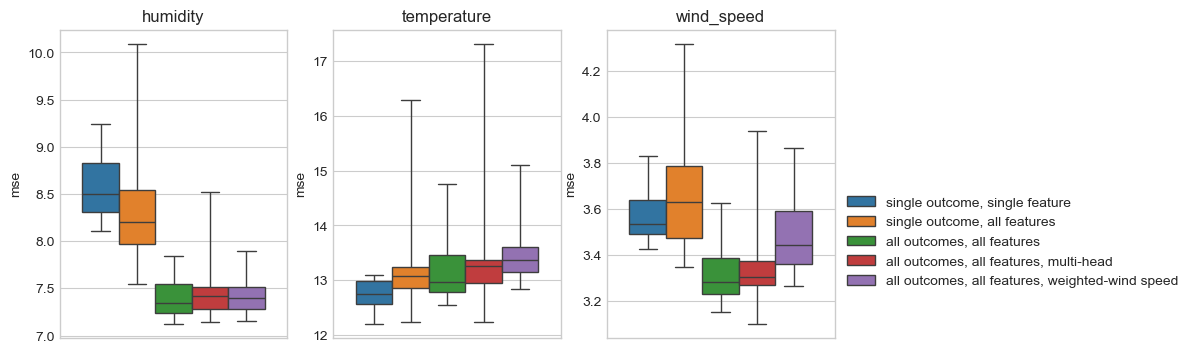

In [18]:
plot_df = losses_repeat_trials.filter((pl.col("fold") == "test")).rename(
    {"col": "outcome"}
)

outcomes = plot_df["outcome"].unique().sort()
fig, ax = plt.subplots(figsize=(10, 4), ncols=len(outcomes))
for idx, outcome in enumerate(outcomes):
    sns.boxplot(
        data=plot_df.filter(pl.col("outcome") == outcome),
        y="mse",
        hue="model_name",
        whis=100,
        ax=ax[idx],
    )
    ax[idx].get_legend().remove()
    ax[idx].set(title=outcome)

ax[-1].legend(loc="upper left", bbox_to_anchor=(1, 0.5))
fig.show()

We see that adding all the features doesn't always improve performance on humidity and wind speed, but adding the addition outcomes into a multi task model improves performance.

Temperature is independent from wind speed and humidity, so it makes sense that adding in extra features and outcomes won't help temperature predictions.

# Appendix

Performance degrades when we add outcomes
* Has MSE converged? Yes
* Windspeed only model is likely best possible performance
  * We have enough data to optimise for windspeed alone.
* The model doesnt have expressiveness to model all outcomes in current architecture.
  * Increasing width - doesnt change performance
  * multi heads/deep/wider?
Different scales = different weighting in MSE
* Cross validate - changing seed

In [19]:
raise NotImplementedError

NotImplementedError: 

## Test case

In [ ]:
df_train = df_lagged[: int(df_lagged.shape[0] * 0.75)]
df_test = df_lagged[int(df_lagged.shape[0] * 0.75) :]


In [ ]:
outcome_cols = ["temperature"]

feature_cols = get_features_from_outcomes(df_lagged, outcome_cols)
dataloader_train = dataloader_from_df(df_train, feature_cols, outcome_cols)
dataloader_test = dataloader_from_df(df_test, feature_cols, outcome_cols)
data_batch = next(iter(dataloader_train))
print("features: ", len(feature_cols), "data_batch shape: ", data_batch[0].shape)

features:  8 data_batch shape:  torch.Size([1024, 8])


In [ ]:
torch.manual_seed(1)
model = SimpleMLP(
    input_dim=len(feature_cols), output_dim=len(outcome_cols), learning_rate=1e-3
)
data_batch = next(iter(dataloader_train))
y_est = model(data_batch[0])
y_est, model.loss(data_batch[1], y_est)

(tensor([[ 0.0346],
         [ 0.0197],
         [-0.0808],
         ...,
         [ 0.0870],
         [ 0.0401],
         [-0.0800]], grad_fn=<AddmmBackward0>),
 tensor(71.1806, grad_fn=<MseLossBackward0>))

In [ ]:
trainer = pyl.Trainer(max_epochs=10, accelerator="mps")
trainer.fit(model, dataloader_train)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/stantoon/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:108: PossibleUserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn(

  | Name | Type       | Params
------------------------------------
0 | net  | Sequential | 1.4 K 
1 | loss | MSELoss    | 0     
------------------------------------
1.4 K     Trainable params
0         Non-trainable params
1.4 K     Total params
0.006     Total estimated model params size (MB)
/Users/stantoon/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argumen

Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


/var/folders/_v/nlh4h1yx2n1gd6f3szjlgxt40000gr/T/ipykernel_61929/3821579680.py:33: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


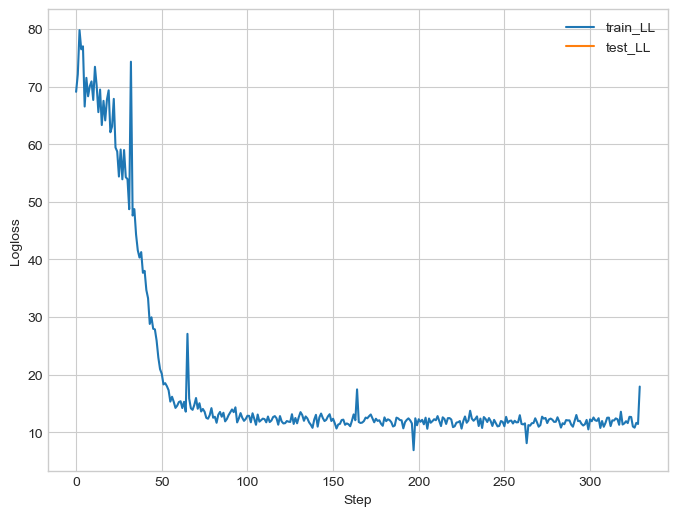

In [ ]:
plot_training_logs(model)

Overall loss

In [ ]:
print(calculate_loss(model, outcome_cols, dataloader_train))
print(calculate_loss(model, outcome_cols, dataloader_test))

[{'col': 'temperature', 'mse': 11.865683555603027}]
[{'col': 'temperature', 'mse': 11.891058921813965}]


Plot predictions

/var/folders/_v/nlh4h1yx2n1gd6f3szjlgxt40000gr/T/ipykernel_61929/3821579680.py:69: DeprecationWarning: `DataFrame.melt` is deprecated. Use `unpivot` instead, with `index` instead of `id_vars` and `on` instead of `value_vars`
  data=df_train_est.melt(
/var/folders/_v/nlh4h1yx2n1gd6f3szjlgxt40000gr/T/ipykernel_61929/3821579680.py:78: DeprecationWarning: `DataFrame.melt` is deprecated. Use `unpivot` instead, with `index` instead of `id_vars` and `on` instead of `value_vars`
  data=df_test_est.melt(


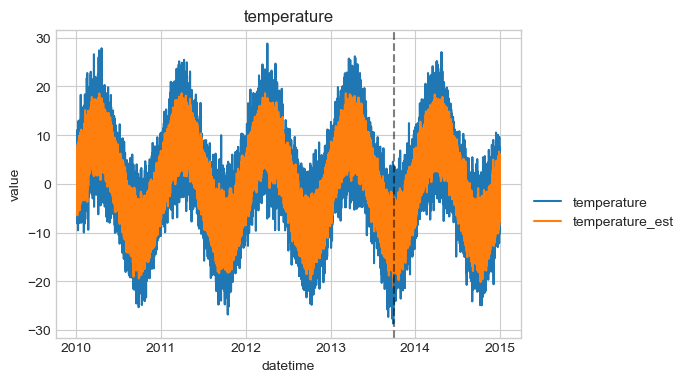

In [ ]:
df_train_est = get_predictions(df_train, model, feature_cols, outcome_cols)
df_test_est = get_predictions(df_test, model, feature_cols, outcome_cols)
plot_predictions(df_train_est, df_test_est, outcome_cols)

#### Single outcome models

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/stantoon/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:108: PossibleUserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn(

  | Name | Type       | Params
------------------------------------
0 | net  | Sequential | 1.4 K 
1 | loss | MSELoss    | 0     
------------------------------------
1.4 K     Trainable params
0         Non-trainable params
1.4 K     Total params
0.006     Total estimated model params size (MB)
/Users/stantoon/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argumen

Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
/var/folders/_v/nlh4h1yx2n1gd6f3szjlgxt40000gr/T/ipykernel_61929/3821579680.py:33: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/var/folders/_v/nlh4h1yx2n1gd6f3szjlgxt40000gr/T/ipykernel_61929/3821579680.py:69: DeprecationWarning: `DataFrame.melt` is deprecated. Use `unpivot` instead, with `index` instead of `id_vars` and `on` instead of `value_vars`
  data=df_train_est.melt(
/var/folders/_v/nlh4h1yx2n1gd6f3szjlgxt40000gr/T/ipykernel_61929/3821579680.py:78: DeprecationWarning: `DataFrame.melt` is deprecated. Use `unpivot` instead, with `index` instead of `id_vars` and `on` instead of `value_vars`
  data=df_test_est.melt(
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/stantoon/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:108

Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
/var/folders/_v/nlh4h1yx2n1gd6f3szjlgxt40000gr/T/ipykernel_61929/3821579680.py:33: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/var/folders/_v/nlh4h1yx2n1gd6f3szjlgxt40000gr/T/ipykernel_61929/3821579680.py:69: DeprecationWarning: `DataFrame.melt` is deprecated. Use `unpivot` instead, with `index` instead of `id_vars` and `on` instead of `value_vars`
  data=df_train_est.melt(
/var/folders/_v/nlh4h1yx2n1gd6f3szjlgxt40000gr/T/ipykernel_61929/3821579680.py:78: DeprecationWarning: `DataFrame.melt` is deprecated. Use `unpivot` instead, with `index` instead of `id_vars` and `on` instead of `value_vars`
  data=df_test_est.melt(
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/stantoon/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:108

Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
/var/folders/_v/nlh4h1yx2n1gd6f3szjlgxt40000gr/T/ipykernel_61929/3821579680.py:33: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/var/folders/_v/nlh4h1yx2n1gd6f3szjlgxt40000gr/T/ipykernel_61929/3821579680.py:69: DeprecationWarning: `DataFrame.melt` is deprecated. Use `unpivot` instead, with `index` instead of `id_vars` and `on` instead of `value_vars`
  data=df_train_est.melt(
/var/folders/_v/nlh4h1yx2n1gd6f3szjlgxt40000gr/T/ipykernel_61929/3821579680.py:78: DeprecationWarning: `DataFrame.melt` is deprecated. Use `unpivot` instead, with `index` instead of `id_vars` and `on` instead of `value_vars`
  data=df_test_est.melt(


outcome_cols,fold,col,mse
str,str,str,f64
"""humidity""","""test""","""humidity""",8.281941
"""humidity""","""train""","""humidity""",5.619501
"""temperature""","""test""","""temperature""",12.866879
"""temperature""","""train""","""temperature""",10.540162
"""wind_speed""","""test""","""wind_speed""",3.384507
"""wind_speed""","""train""","""wind_speed""",2.976811


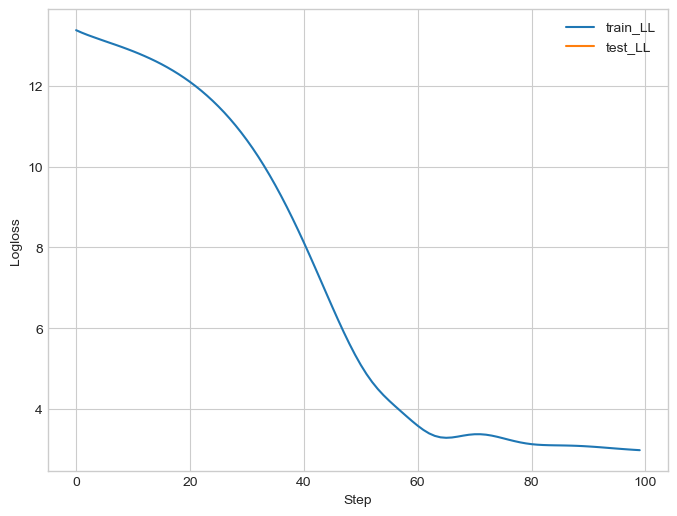

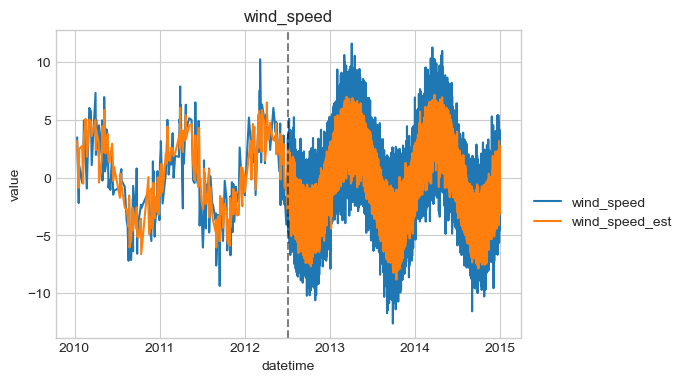

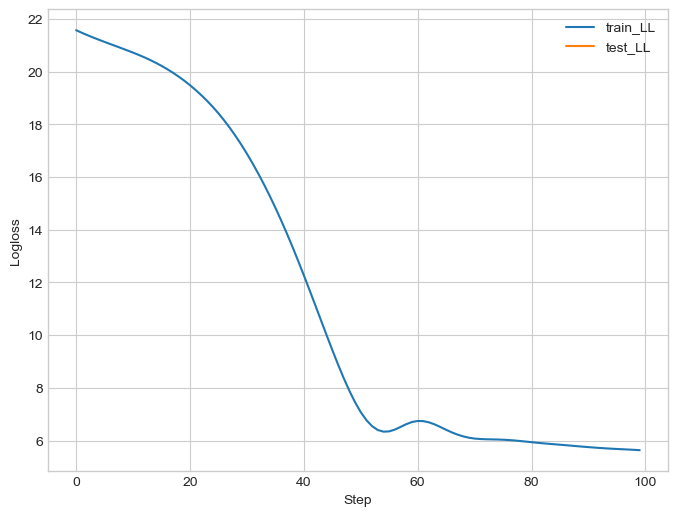

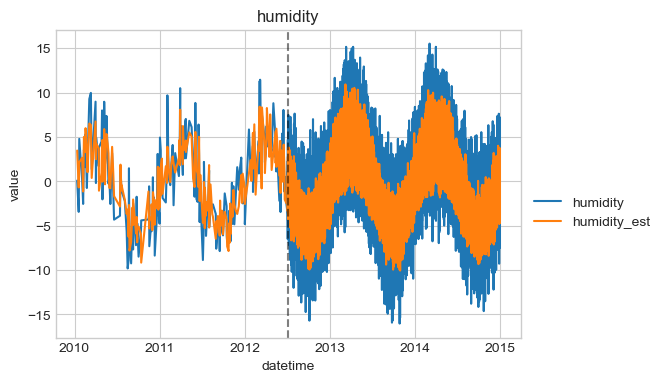

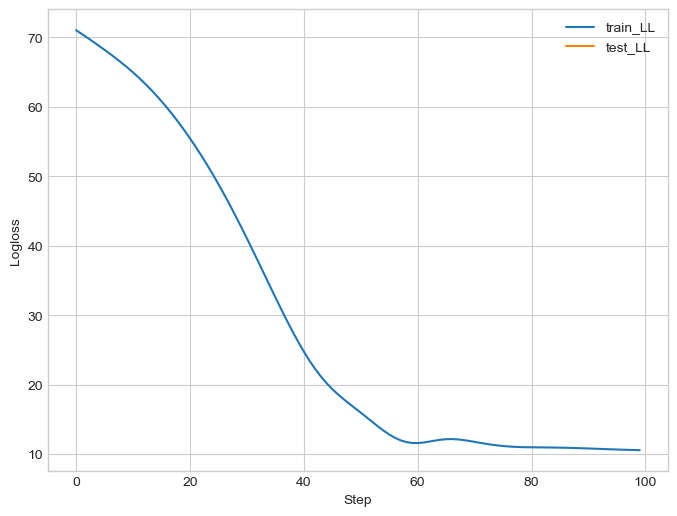

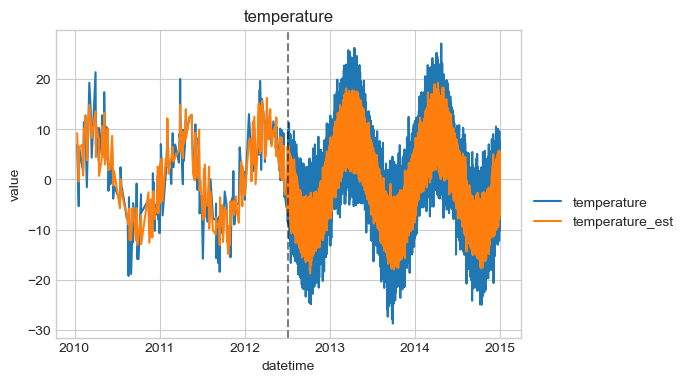

In [ ]:
outcome_groups = [
    ["wind_speed"],
    ["humidity"],
    ["temperature"],
]
losses = []
for outcome_cols in outcome_groups:
    loss_train, loss_test = loss_from_outcomes(
        outcome_cols=outcome_cols,
        model_callable=lambda feature_cols, outcome_cols: SimpleMLP(
            input_dim=len(feature_cols),
            output_dim=len(outcome_cols),
            learning_rate=1e-3,
        ),
        debug=True,
    )
    losses.extend(
        [
            {"outcome_cols": "_".join(outcome_cols), "fold": "train", **loss}
            for loss in loss_train
        ]
    )
    losses.extend(
        [
            {"outcome_cols": "_".join(outcome_cols), "fold": "test", **loss}
            for loss in loss_test
        ]
    )

losses_single_output = pl.DataFrame(losses)
losses_single_output.sort(["col", "fold", "outcome_cols"])

We can fit each time series by itself fine.

#### Testing multiple outcomes

Adding another output, does it improve loss on the first outcome?

Humidity/windspeed are based on temp, so include temp as a second outcome.
We will model wind speed and aim to improve its predictions by considering humidity and temperature.

In [ ]:
outcome_groups = [
    ["wind_speed"],
    ["humidity", "wind_speed"],
    ["temperature", "humidity", "wind_speed"],
]
losses = []
for outcome_cols in outcome_groups:
    loss_train, loss_test = loss_from_outcomes(
        outcome_cols=outcome_cols,
        model_callable=lambda feature_cols, outcome_cols: SimpleMLP(
            input_dim=len(feature_cols),
            output_dim=len(outcome_cols),
            learning_rate=1e-3,
        ),
        debug=False,
    )
    losses.extend(
        [
            {"outcome_cols": "_".join(outcome_cols), "fold": "train", **loss}
            for loss in loss_train
        ]
    )
    losses.extend(
        [
            {"outcome_cols": "_".join(outcome_cols), "fold": "test", **loss}
            for loss in loss_test
        ]
    )

losses = pl.DataFrame(losses)
losses.sort(["col", "fold", "outcome_cols"]).filter(pl.col("col") == "wind_speed")

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/stantoon/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:108: PossibleUserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn(
/Users/stantoon/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/Users/stantoon/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/pytorch_lightning/trainer/trainer.py:1609: PossibleUserWarning: The number of training batches (1) is s

outcome_cols,fold,col,mse
str,str,str,f64
"""humidity_wind_speed""","""test""","""wind_speed""",3.475817
"""temperature_humidity_wind_spee…","""test""","""wind_speed""",3.394049
"""wind_speed""","""test""","""wind_speed""",3.351358
"""humidity_wind_speed""","""train""","""wind_speed""",2.827893
"""temperature_humidity_wind_spee…","""train""","""wind_speed""",2.851132
"""wind_speed""","""train""","""wind_speed""",2.8372


/var/folders/_v/nlh4h1yx2n1gd6f3szjlgxt40000gr/T/ipykernel_61929/1659394447.py:10: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


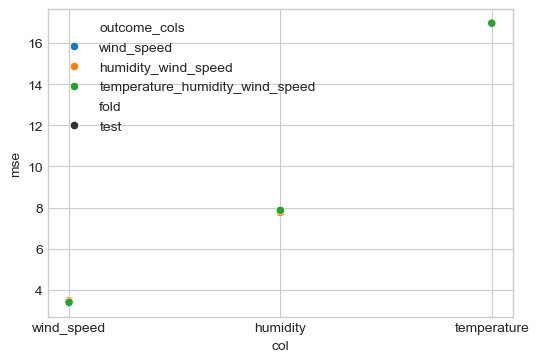

In [ ]:
fig, ax = plt.subplots(figsize=(6, 4))
sns.scatterplot(
    data=losses.filter(pl.col("fold") == "test"),
    x="col",
    y="mse",
    hue="outcome_cols",
    style="fold",
    ax=ax,
)
fig.show()

Add more outcomes has made the performance on wind_speed worse

### Less data

Does the performance on the wind speed model already saturate with our data length?
If so, can we reduce and expect better gains from multi task learning?

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/stantoon/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:108: PossibleUserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn(

  | Name | Type       | Params
------------------------------------
0 | net  | Sequential | 1.4 K 
1 | loss | MSELoss    | 0     
------------------------------------
1.4 K     Trainable params
0         Non-trainable params
1.4 K     Total params
0.006     Total estimated model params size (MB)
/Users/stantoon/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argumen

Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=500` reached.
/var/folders/_v/nlh4h1yx2n1gd6f3szjlgxt40000gr/T/ipykernel_61929/3821579680.py:33: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/var/folders/_v/nlh4h1yx2n1gd6f3szjlgxt40000gr/T/ipykernel_61929/3821579680.py:69: DeprecationWarning: `DataFrame.melt` is deprecated. Use `unpivot` instead, with `index` instead of `id_vars` and `on` instead of `value_vars`
  data=df_train_est.melt(
/var/folders/_v/nlh4h1yx2n1gd6f3szjlgxt40000gr/T/ipykernel_61929/3821579680.py:78: DeprecationWarning: `DataFrame.melt` is deprecated. Use `unpivot` instead, with `index` instead of `id_vars` and `on` instead of `value_vars`
  data=df_test_est.melt(
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/stantoon/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:108

Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=500` reached.
/var/folders/_v/nlh4h1yx2n1gd6f3szjlgxt40000gr/T/ipykernel_61929/3821579680.py:33: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/var/folders/_v/nlh4h1yx2n1gd6f3szjlgxt40000gr/T/ipykernel_61929/3821579680.py:69: DeprecationWarning: `DataFrame.melt` is deprecated. Use `unpivot` instead, with `index` instead of `id_vars` and `on` instead of `value_vars`
  data=df_train_est.melt(
/var/folders/_v/nlh4h1yx2n1gd6f3szjlgxt40000gr/T/ipykernel_61929/3821579680.py:78: DeprecationWarning: `DataFrame.melt` is deprecated. Use `unpivot` instead, with `index` instead of `id_vars` and `on` instead of `value_vars`
  data=df_test_est.melt(
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/stantoon/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:108

Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=500` reached.
/var/folders/_v/nlh4h1yx2n1gd6f3szjlgxt40000gr/T/ipykernel_61929/3821579680.py:33: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/var/folders/_v/nlh4h1yx2n1gd6f3szjlgxt40000gr/T/ipykernel_61929/3821579680.py:69: DeprecationWarning: `DataFrame.melt` is deprecated. Use `unpivot` instead, with `index` instead of `id_vars` and `on` instead of `value_vars`
  data=df_train_est.melt(
/var/folders/_v/nlh4h1yx2n1gd6f3szjlgxt40000gr/T/ipykernel_61929/3821579680.py:78: DeprecationWarning: `DataFrame.melt` is deprecated. Use `unpivot` instead, with `index` instead of `id_vars` and `on` instead of `value_vars`
  data=df_test_est.melt(


outcome_cols,fold,col,mse
str,str,str,f64
"""humidity""","""test""","""humidity""",13.984738
"""humidity""","""train""","""humidity""",0.992045
"""temperature""","""test""","""temperature""",15.998935
"""temperature""","""train""","""temperature""",5.443322
"""wind_speed""","""test""","""wind_speed""",5.027757
"""wind_speed""","""train""","""wind_speed""",0.626364


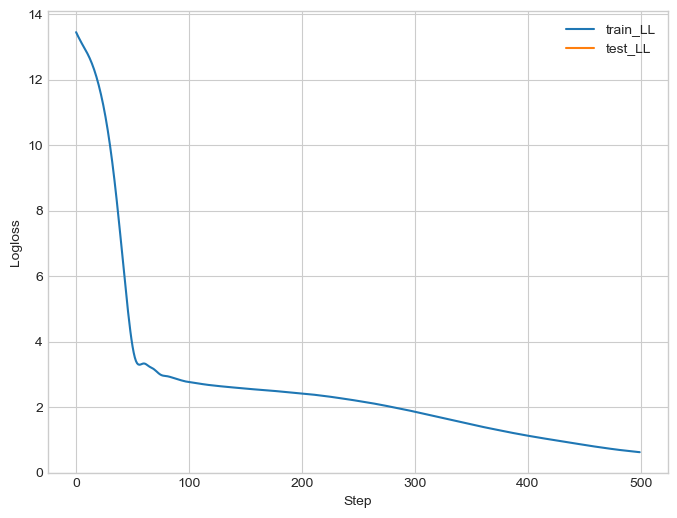

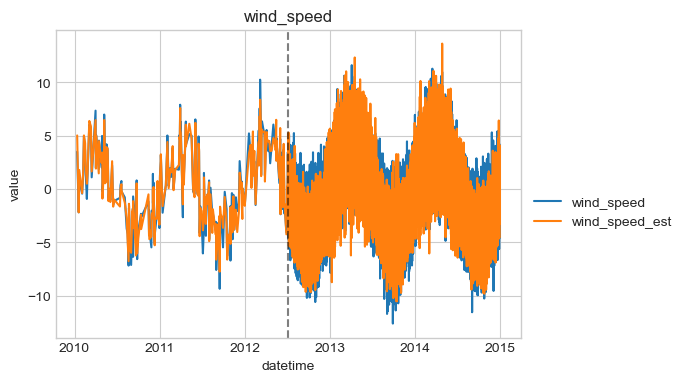

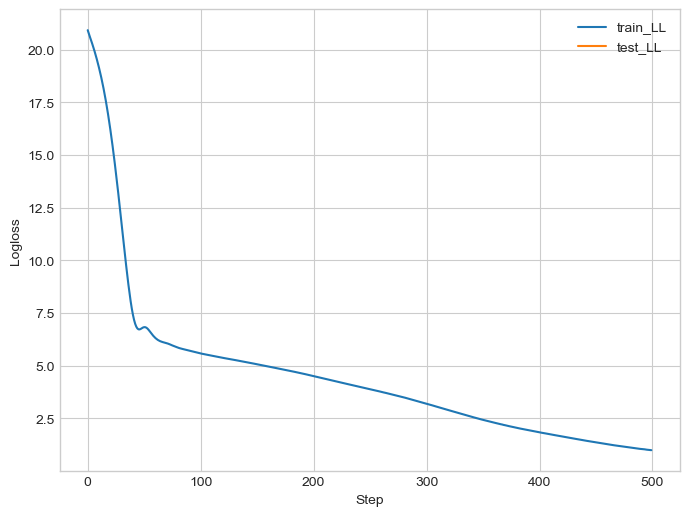

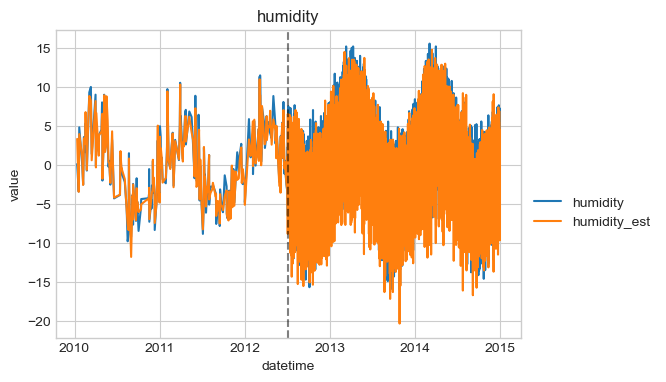

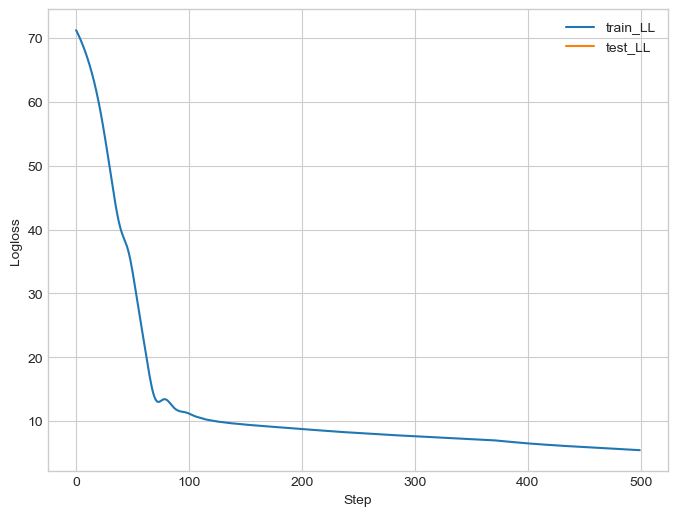

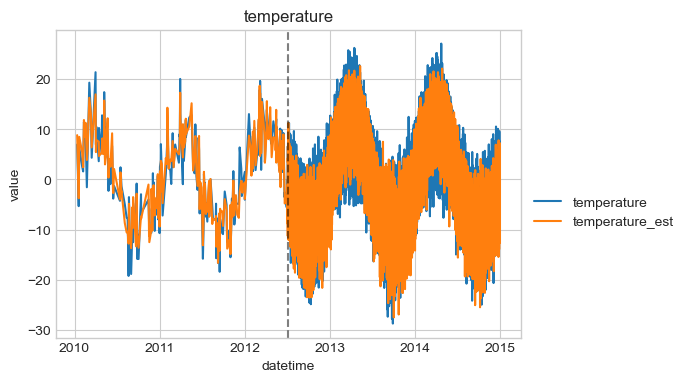

In [ ]:
outcome_groups = [
    ["wind_speed"],
    ["humidity"],
    ["temperature"],
]
losses = []
df_train = df_lagged[: int(df_lagged.shape[0] * 0.5)].sample(fraction=0.01, seed=0)
df_test = df_lagged[int(df_lagged.shape[0] * 0.5) :]
for outcome_cols in outcome_groups:
    loss_train, loss_test = loss_from_outcomes(
        outcome_cols=outcome_cols,
        model_callable=lambda feature_cols, outcome_cols: SimpleMLP(
            input_dim=len(feature_cols),
            output_dim=len(outcome_cols),
            learning_rate=1e-3,
        ),
        df_train=df_train,
        df_test=df_test,
        debug=True,
        epochs=500,
    )
    losses.extend(
        [
            {"outcome_cols": "_".join(outcome_cols), "fold": "train", **loss}
            for loss in loss_train
        ]
    )
    losses.extend(
        [
            {"outcome_cols": "_".join(outcome_cols), "fold": "test", **loss}
            for loss in loss_test
        ]
    )

losses_less_data = pl.DataFrame(losses)
losses_less_data.sort(["col", "fold", "outcome_cols"])

Fitting on a much smaller sample creates worse models.

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/stantoon/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:108: PossibleUserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn(

  | Name | Type       | Params
------------------------------------
0 | net  | Sequential | 1.9 K 
1 | loss | MSELoss    | 0     
------------------------------------
1.9 K     Trainable params
0         Non-trainable params
1.9 K     Total params
0.008     Total estimated model params size (MB)
/Users/stantoon/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argumen

Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=500` reached.
/var/folders/_v/nlh4h1yx2n1gd6f3szjlgxt40000gr/T/ipykernel_61929/3821579680.py:33: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/var/folders/_v/nlh4h1yx2n1gd6f3szjlgxt40000gr/T/ipykernel_61929/3821579680.py:69: DeprecationWarning: `DataFrame.melt` is deprecated. Use `unpivot` instead, with `index` instead of `id_vars` and `on` instead of `value_vars`
  data=df_train_est.melt(
/var/folders/_v/nlh4h1yx2n1gd6f3szjlgxt40000gr/T/ipykernel_61929/3821579680.py:78: DeprecationWarning: `DataFrame.melt` is deprecated. Use `unpivot` instead, with `index` instead of `id_vars` and `on` instead of `value_vars`
  data=df_test_est.melt(
/var/folders/_v/nlh4h1yx2n1gd6f3szjlgxt40000gr/T/ipykernel_61929/3821579680.py:69: DeprecationWarning: `DataFrame.melt` is deprecated. Use `unpivot` instead, with `index` instead of `id_vars` and `on` instead of `value_vars`
  data=df_train_est.melt(
/var/folders/_v/nlh4h1yx2n1gd

outcome_cols,fold,col,mse
str,str,str,f64
"""temperature_humidity_wind_spee…","""test""","""wind_speed""",5.238291
"""temperature_humidity_wind_spee…","""train""","""wind_speed""",1.07037


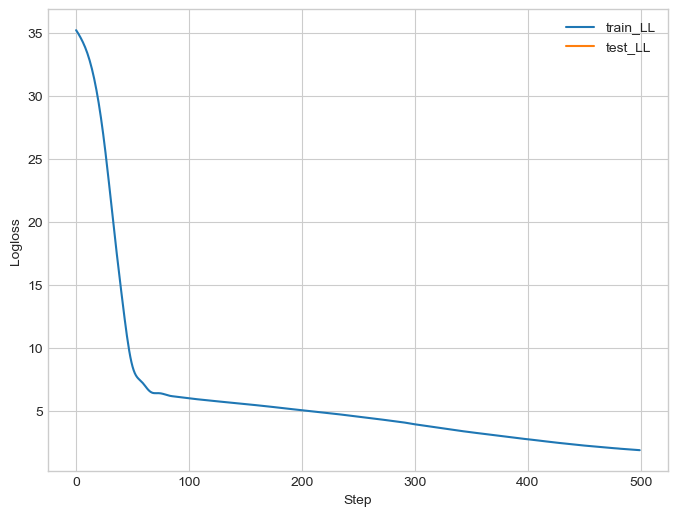

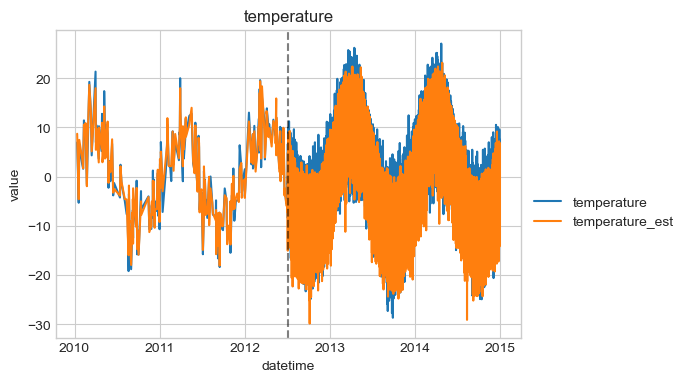

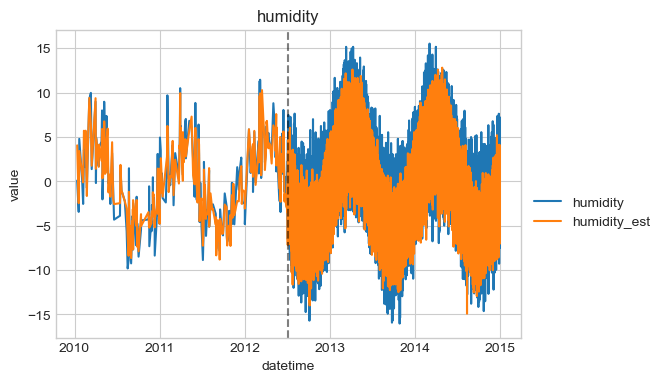

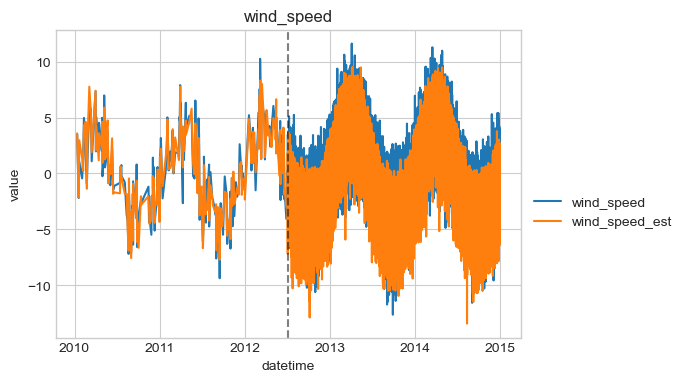

In [ ]:
outcome_groups = [
    ["temperature", "humidity", "wind_speed"],
]
losses = []
df_train = df_lagged[: int(df_lagged.shape[0] * 0.5)].sample(fraction=0.01, seed=0)
df_test = df_lagged[int(df_lagged.shape[0] * 0.5) :]
for outcome_cols in outcome_groups:
    loss_train, loss_test = loss_from_outcomes(
        outcome_cols=outcome_cols,
        model_callable=lambda feature_cols, outcome_cols: SimpleMLP(
            input_dim=len(feature_cols),
            output_dim=len(outcome_cols),
            learning_rate=1e-3,
        ),
        df_train=df_train,
        df_test=df_test,
        debug=True,
        epochs=500,
    )
    losses.extend(
        [
            {"outcome_cols": "_".join(outcome_cols), "fold": "train", **loss}
            for loss in loss_train
        ]
    )
    losses.extend(
        [
            {"outcome_cols": "_".join(outcome_cols), "fold": "test", **loss}
            for loss in loss_test
        ]
    )

losses_combined_model = pl.DataFrame(losses)
losses_combined_model.sort(["col", "fold", "outcome_cols"]).filter(
    pl.col("col") == "wind_speed"
)

Comparing results

In [ ]:
display(losses_single_output.sort(["col", "fold", "outcome_cols"]))
display(losses_less_data.sort(["col", "fold", "outcome_cols"]))
display(losses_combined_model.sort(["col", "fold", "outcome_cols"]))

outcome_cols,fold,col,mse
str,str,str,f64
"""humidity""","""test""","""humidity""",8.281941
"""humidity""","""train""","""humidity""",5.619501
"""temperature""","""test""","""temperature""",12.866879
"""temperature""","""train""","""temperature""",10.540162
"""wind_speed""","""test""","""wind_speed""",3.384507
"""wind_speed""","""train""","""wind_speed""",2.976811


outcome_cols,fold,col,mse
str,str,str,f64
"""humidity""","""test""","""humidity""",13.984738
"""humidity""","""train""","""humidity""",0.992045
"""temperature""","""test""","""temperature""",15.998935
"""temperature""","""train""","""temperature""",5.443322
"""wind_speed""","""test""","""wind_speed""",5.027757
"""wind_speed""","""train""","""wind_speed""",0.626364


outcome_cols,fold,col,mse
str,str,str,f64
"""temperature_humidity_wind_spee…","""test""","""humidity""",10.099348
"""temperature_humidity_wind_spee…","""train""","""humidity""",2.505691
"""temperature_humidity_wind_spee…","""test""","""temperature""",21.00275
"""temperature_humidity_wind_spee…","""train""","""temperature""",2.103837
"""temperature_humidity_wind_spee…","""test""","""wind_speed""",5.238291
"""temperature_humidity_wind_spee…","""train""","""wind_speed""",1.07037


Multi tasks generally improve performance. Temperature does not improve on test sets... this is likely due to temperature being derived separately, whereas humidity is derived from temperature and wind speed is derived from both.

Is this due to the lagged features or the extra outcome prediction tasks?

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/stantoon/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:108: PossibleUserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn(

  | Name | Type       | Params
------------------------------------
0 | net  | Sequential | 1.9 K 
1 | loss | MSELoss    | 0     
------------------------------------
1.9 K     Trainable params
0         Non-trainable params
1.9 K     Total params
0.008     Total estimated model params size (MB)
/Users/stantoon/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argumen

Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=500` reached.
/var/folders/_v/nlh4h1yx2n1gd6f3szjlgxt40000gr/T/ipykernel_61929/3821579680.py:33: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/var/folders/_v/nlh4h1yx2n1gd6f3szjlgxt40000gr/T/ipykernel_61929/3821579680.py:69: DeprecationWarning: `DataFrame.melt` is deprecated. Use `unpivot` instead, with `index` instead of `id_vars` and `on` instead of `value_vars`
  data=df_train_est.melt(
/var/folders/_v/nlh4h1yx2n1gd6f3szjlgxt40000gr/T/ipykernel_61929/3821579680.py:78: DeprecationWarning: `DataFrame.melt` is deprecated. Use `unpivot` instead, with `index` instead of `id_vars` and `on` instead of `value_vars`
  data=df_test_est.melt(
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/stantoon/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:108

Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=500` reached.
/var/folders/_v/nlh4h1yx2n1gd6f3szjlgxt40000gr/T/ipykernel_61929/3821579680.py:33: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/var/folders/_v/nlh4h1yx2n1gd6f3szjlgxt40000gr/T/ipykernel_61929/3821579680.py:69: DeprecationWarning: `DataFrame.melt` is deprecated. Use `unpivot` instead, with `index` instead of `id_vars` and `on` instead of `value_vars`
  data=df_train_est.melt(
/var/folders/_v/nlh4h1yx2n1gd6f3szjlgxt40000gr/T/ipykernel_61929/3821579680.py:78: DeprecationWarning: `DataFrame.melt` is deprecated. Use `unpivot` instead, with `index` instead of `id_vars` and `on` instead of `value_vars`
  data=df_test_est.melt(
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/stantoon/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:108

Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=500` reached.
/var/folders/_v/nlh4h1yx2n1gd6f3szjlgxt40000gr/T/ipykernel_61929/3821579680.py:33: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/var/folders/_v/nlh4h1yx2n1gd6f3szjlgxt40000gr/T/ipykernel_61929/3821579680.py:69: DeprecationWarning: `DataFrame.melt` is deprecated. Use `unpivot` instead, with `index` instead of `id_vars` and `on` instead of `value_vars`
  data=df_train_est.melt(
/var/folders/_v/nlh4h1yx2n1gd6f3szjlgxt40000gr/T/ipykernel_61929/3821579680.py:78: DeprecationWarning: `DataFrame.melt` is deprecated. Use `unpivot` instead, with `index` instead of `id_vars` and `on` instead of `value_vars`
  data=df_test_est.melt(


outcome_cols,fold,col,mse
str,str,str,f64
"""humidity""","""test""","""humidity""",15.121475
"""humidity""","""train""","""humidity""",0.250763
"""temperature""","""test""","""temperature""",19.410362
"""temperature""","""train""","""temperature""",2.012214
"""wind_speed""","""test""","""wind_speed""",7.385959
"""wind_speed""","""train""","""wind_speed""",0.129393


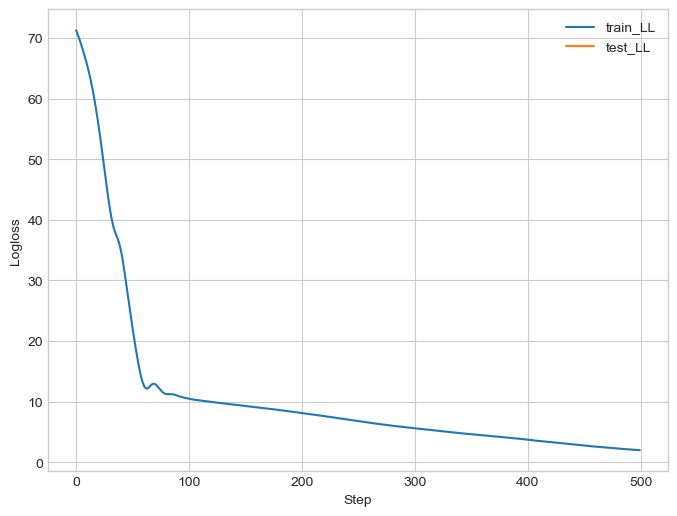

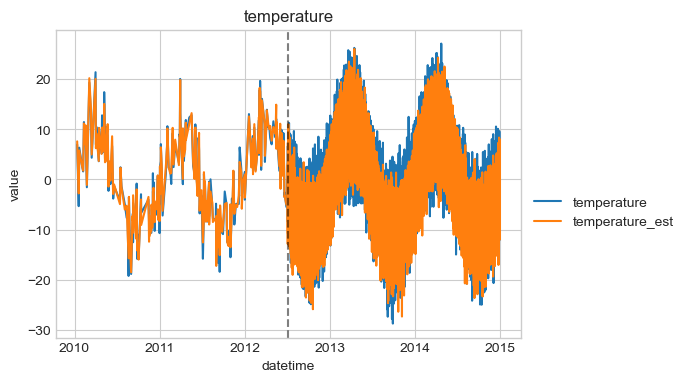

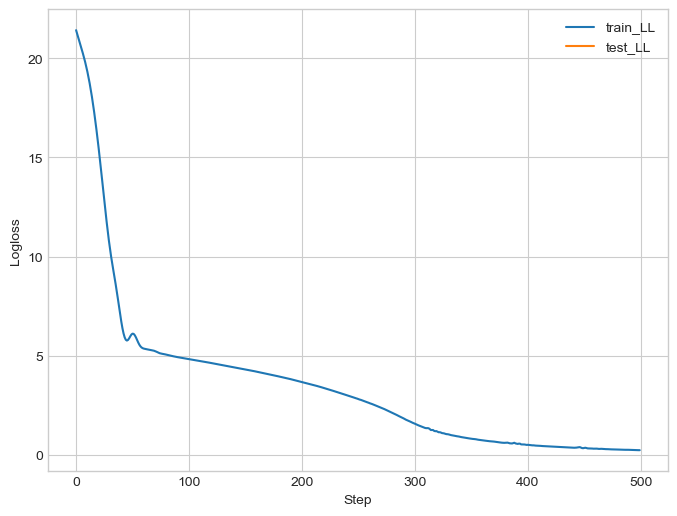

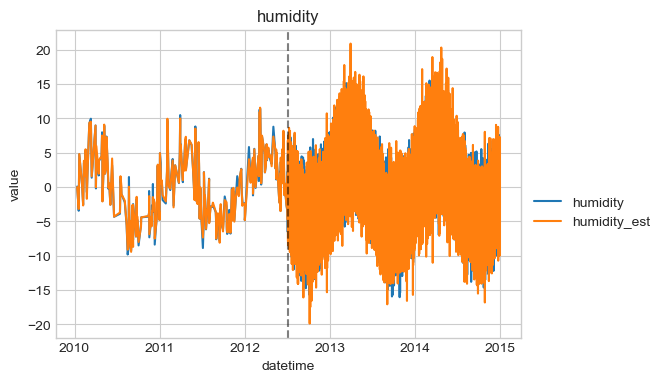

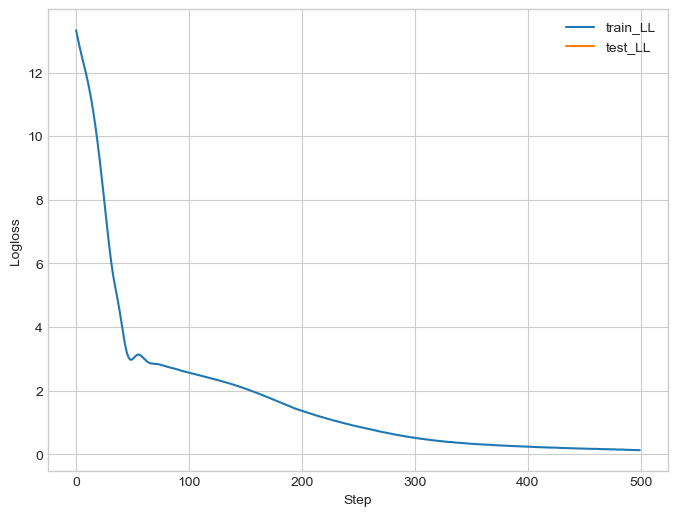

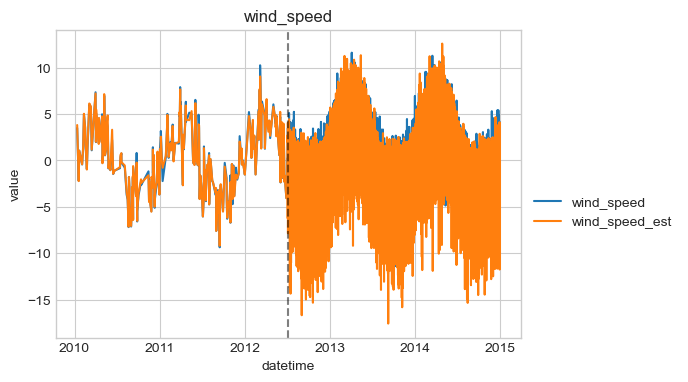

In [ ]:
outcome_groups = [
    ["temperature"],
    ["humidity"],
    ["wind_speed"],
]
losses = []
df_train = df_lagged[: int(df_lagged.shape[0] * 0.5)].sample(fraction=0.01, seed=0)
df_test = df_lagged[int(df_lagged.shape[0] * 0.5) :]
for outcome_cols in outcome_groups:
    loss_train, loss_test = loss_from_outcomes(
        outcome_cols=outcome_cols,
        feature_cols=get_features_from_outcomes(
            df_train, ["temperature", "humidity", "wind_speed"]
        ),
        model_callable=lambda feature_cols, outcome_cols: SimpleMLP(
            input_dim=len(feature_cols),
            output_dim=len(outcome_cols),
            learning_rate=1e-3,
        ),
        df_train=df_train,
        df_test=df_test,
        debug=True,
        epochs=500,
    )
    losses.extend(
        [
            {"outcome_cols": "_".join(outcome_cols), "fold": "train", **loss}
            for loss in loss_train
        ]
    )
    losses.extend(
        [
            {"outcome_cols": "_".join(outcome_cols), "fold": "test", **loss}
            for loss in loss_test
        ]
    )

losses_all_features = pl.DataFrame(losses)
losses_all_features.sort(["col", "fold", "outcome_cols"])

Using all the features does not improve performance, its the additional tasks that matter as well.
Using all features introduced more overfitting. The extra outcomes help regulate the overfit.

In [ ]:
display(losses_single_output.sort(["col", "fold", "outcome_cols"]))
display(losses_less_data.sort(["col", "fold", "outcome_cols"]))
display(losses_combined_model.sort(["col", "fold", "outcome_cols"]))
display(losses_all_features.sort(["col", "fold", "outcome_cols"]))

outcome_cols,fold,col,mse
str,str,str,f64
"""humidity""","""test""","""humidity""",8.281941
"""humidity""","""train""","""humidity""",5.619501
"""temperature""","""test""","""temperature""",12.866879
"""temperature""","""train""","""temperature""",10.540162
"""wind_speed""","""test""","""wind_speed""",3.384507
"""wind_speed""","""train""","""wind_speed""",2.976811


outcome_cols,fold,col,mse
str,str,str,f64
"""humidity""","""test""","""humidity""",13.984738
"""humidity""","""train""","""humidity""",0.992045
"""temperature""","""test""","""temperature""",15.998935
"""temperature""","""train""","""temperature""",5.443322
"""wind_speed""","""test""","""wind_speed""",5.027757
"""wind_speed""","""train""","""wind_speed""",0.626364


outcome_cols,fold,col,mse
str,str,str,f64
"""temperature_humidity_wind_spee…","""test""","""humidity""",10.099348
"""temperature_humidity_wind_spee…","""train""","""humidity""",2.505691
"""temperature_humidity_wind_spee…","""test""","""temperature""",21.00275
"""temperature_humidity_wind_spee…","""train""","""temperature""",2.103837
"""temperature_humidity_wind_spee…","""test""","""wind_speed""",5.238291
"""temperature_humidity_wind_spee…","""train""","""wind_speed""",1.07037


outcome_cols,fold,col,mse
str,str,str,f64
"""humidity""","""test""","""humidity""",15.121475
"""humidity""","""train""","""humidity""",0.250763
"""temperature""","""test""","""temperature""",19.410362
"""temperature""","""train""","""temperature""",2.012214
"""wind_speed""","""test""","""wind_speed""",7.385959
"""wind_speed""","""train""","""wind_speed""",0.129393


In [ ]:
losses_repeat_trials_grouped = (
    losses_repeat_trials.group_by(["outcome_cols", "feature_cols"])
    .agg(
        [
            pl.col("mse")
            .filter((pl.col("col") == col) & (pl.col("fold") == "train"))
            .mean()
            .alias(f"{col}_train")
            for col in outcomes
        ]
        + [
            pl.col("mse")
            .filter((pl.col("col") == col) & (pl.col("fold") == "test"))
            .mean()
            .alias(f"{col}_test")
            for col in outcomes
        ]
        + [
            pl.col("mse")
            .filter((pl.col("col") == col) & (pl.col("fold") == "train"))
            .std()
            .alias(f"{col}_std_train")
            for col in outcomes
        ]
        + [
            pl.col("mse")
            .filter((pl.col("col") == col) & (pl.col("fold") == "test"))
            .std()
            .alias(f"{col}_std_test")
            for col in outcomes
        ]
    )
    .sort(["outcome_cols", "feature_cols"])
)
with pl.Config(set_tbl_rows=50):
    display(losses_repeat_trials_grouped)

NameError: name 'outcomes' is not defined

In [ ]:
with pl.Config(set_tbl_rows=50):
    display(losses_repeat_trials_grouped)

outcome_cols,feature_cols,temperature_train,humidity_train,wind_speed_train,temperature_test,humidity_test,wind_speed_test,temperature_std_train,humidity_std_train,wind_speed_std_train,temperature_std_test,humidity_std_test,wind_speed_std_test
str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""humidity""","""humidity""",null,0.596702,null,null,16.444454,null,null,0.191394,null,null,1.299552,null
"""humidity""","""temperature_humidity_wind_spee…",null,0.286501,null,null,14.881797,null,null,0.31028,null,null,0.789743,null
"""temperature""","""temperature""",4.820924,null,null,17.153095,null,null,1.595599,null,null,2.435004,null,null
"""temperature""","""temperature_humidity_wind_spee…",2.415854,null,null,21.561631,null,null,0.915835,null,null,1.935419,null,null
"""temperature_humidity_wind_spee…","""temperature_humidity_wind_spee…",2.663173,2.661686,1.090912,20.603559,11.047653,4.960344,0.965158,0.472047,0.261558,1.637676,0.699758,0.185349
"""wind_speed""","""temperature_humidity_wind_spee…",null,null,0.144996,null,null,6.561756,null,null,0.073652,null,null,0.696858
"""wind_speed""","""wind_speed""",null,null,0.578599,null,null,6.344272,null,null,0.172146,null,null,0.605309
